## Commuting distance per occupation: analysis
This notebook is to analyse the average distance travelled per occupation across different travel to work areas (TTWA). For each output area (OA), or lower super output area (LSOA) in a TTWA, collected using the LMI for ALL API.

The centroids for each OA, or LSOA, are computed in another script (get_oa_lsoa_centroids) using the ONS postcode directory (February 2019). The same dataset also offers a lookup between OAs and TTWAs.

In [1]:
import urllib.request, json
import pandas as pd
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import os
import seaborn as sns
import copy
from importlib import reload
from pandas.plotting import table
# set the default to darkgrid
sns.set_style('darkgrid')

In [2]:
import os
import itertools
import pandas as pd
import numpy as np 
import pickle
import collections
import seaborn as sns
import scipy

# Python tools
from matplotlib import pyplot as plt
import math
from collections import defaultdict
from functools import partial


In [3]:
%matplotlib inline

In [4]:
# import all filenames (stored in a file that is in common to multiple scripts)
import all_filenames
from all_filenames import *

In [5]:
import utils_pin
from utils_pin import print_elapsed

In [8]:
# imports from the mapping environment
#from sklearn import preprocessing
# plotly
import plotly
import plotly.graph_objs as go
import maputils_pin
from maputils_pin import draw_map, draw_map_and_landmarks

plotly.offline.init_notebook_mode(connected=True)


In [25]:
# plot saving folder
plot_save_dir = '/Users/stefgarasto/Google Drive/Documents/results/PIN/plots/'
# file where I'm storing all the information
save_oa_file = res_folder + 'PIN/oa_distances_and_occupations_v2.pickle'
save_oa_file_jobs = res_folder + 'PIN/oa_jobs_breakdown.pickle'
FIGSAVE = True

In [18]:
# first, load the list of all TTWA
ttwa_data = pd.read_csv(ttwa_file)
# first column is ttwa codes, second column is ttwa names
ttwa_info11 = pd.read_excel(ttwa_info11_file)
ttwa_info16 = pd.read_excel(ttwa_info16_file)
#print(ttwa_info11.tail(n=3))
#print(ttwa_info16.tail(n=3))

# get small TTWAs
small_ttwas = list(ttwa_info11['ttwa11cd'][ttwa_info11['LSOAs']<40])
ni_ttwas = list(ttwa_info11['ttwa11cd'][ttwa_info11['ttwa11cd'].map(lambda x: x[0]=='N')])
print('There are {} TTWAs with less than 40 LSOAs.'.format(len(small_ttwas)+len(ni_ttwas)))

# also, eliminate three scottish TTWAs that seem to mostly have nans:
# just joking: can't eliminate Edinburgh and Aberdeen
#bad_ttwas = []#'S22000059', 'S22000047', 'S22000071']
ni_qual = 'no_ni_'
if ni_qual == 'no_ni_':
    small_ttwas = small_ttwas + ni_ttwas#+ bad_ttwas

# now set the ttwa code as the index
ttwa_data = ttwa_data.set_index('ttwa11cd')
ttwa_info11 = ttwa_info11.set_index('ttwa11cd')
ttwa_info16 = ttwa_info16.set_index('ttwa11cd')

# drop rows
ttwa_data = ttwa_data.drop(small_ttwas, axis = 0)
ttwa_info11 = ttwa_info11.drop(small_ttwas, axis = 0)
ttwa_info16 = ttwa_info16.drop([t for t in small_ttwas if t in ttwa_info16.index], axis = 0)
print(len(ttwa_data),len(ttwa_info11),len(ttwa_info16))
ttwa_data = ttwa_data.sort_index()
ttwa_info16 = ttwa_info16.sort_index()
ttwa_info11 = ttwa_info11.sort_index()

# Create aliases for the column names (need to be shorter to be plotted correctly)
rename_cols16 = {'Employment rate ': 'Employment rate',
       '% of economically inactive who want a job':'Job-seeking economically inactive',
       'Claimant Count, % aged 16-64, April 2015 to March 2016 ': 'Claimant count',
       'All in employment who are 1: managers, directors and senior officials (SOC2010)': 'Employed in SOC code 1',
       ' All in employment who are 2: professional occupations or 3: associate prof & tech occupations (SOC2010)': 
                 'Employed in SOC code 2',
       'All in employment who are 5: skilled trades occupations (SOC2010)': 'Employed in SOC code 5',
       'All in employment who are 6: caring, leisure and other service occupations (SOC2010)': 
                 'Employed in SOC code 6',
       'All in employment who are 8: process, plant and machine operatives (SOC2010)':'Employed in SOC code 8',
       'All in employment who are 9: elementary occupations (SOC2010)':'Employed in SOC code 9'}

rename_cols11 = {'Supply-side self-containment (% employed residents who work locally)':
                 'Supply-side self-containment',
       'Demand-side self-containment (% local jobs taken by local residents)':'Demand-side self containment',
       'Number of economically active residents (aged 16+)':'Economically active residents'}
#ttwa_info16 = 
ttwa_info16.rename(rename_cols16, axis = 1, inplace = True)
#ttwa_info11 = 
ttwa_info11.rename(rename_cols11, axis = 1, inplace = True)



There are 65 TTWAs with less than 40 LSOAs.
166 166 166


In [13]:
# load the extracted dictionaries of OA centroids
loadOA = True
loadLSOA = False
oa_path = ons_der_folder + 'oa_centroids_dictionary.pickle'
lsoa_path = ons_der_folder + 'lsoa_centroids_dictionary.pickle'
exists = os.path.isfile(oa_path)
if exists and loadOA:
    print('Loading the OA data')
    oa_data = pd.read_pickle(oa_path)

exists = os.path.isfile(lsoa_path)
if exists and loadLSOA:
    print('Loading the LSOA data')
    lsoa_data = pd.read_pickle(lsoa_path)


Loading the OA data


In [14]:
# Load the data dictionaries which then should be transformed to dataframes and joined.
# They should also be joined with the list of TTWAs for each OA
# Then, I can make the relevant plots
# What I want is a breakdown of mean travel distances for occupations and for ttwa

# first, load the data
with open(save_oa_file, 'rb') as f:
    _,oa_distances,_,oa_residents,socGroups,_,_ = pickle.load(f)

with open(save_oa_file_jobs, 'rb') as f:
    _,oa_number_of_jobs,oa_jobs_breakdown,jobs_socGroups,_,_ = pickle.load(f)

# create the dataframes from the dictionaries and join the data frames
t0 = time.time()
# first create the residents column and change the column title
oa_frame = pd.DataFrame.from_dict(oa_residents, orient = 'index')
# now add everything else
oa_frame.rename(columns = {0: 'residents'}, inplace = True)
oa_frame = oa_frame.join(
    pd.DataFrame.from_dict(oa_distances, orient = 'index')).join(
    pd.DataFrame.from_dict(oa_number_of_jobs, orient = 'index')).join(
    pd.DataFrame.from_dict(oa_jobs_breakdown, orient = 'index')).join(oa_data)
print('It took {:2f}s to create the full dataframe with {} rows'.format(time.time()- t0, len(oa_frame)))
# finally, rename the number of jobs column
oa_frame.rename(columns = {0: 'residents'}, inplace = True)
# What I should have just created is a dataframe that should have each OA as its index, while the columns are:
# breakdown of mean distances (all, male, female, age groups)
# breakdown of occupations per two digit SOC groups (i.e. how many workers in each TTWA for each occupation, in 
# absolute and relative values)
# latitude, longitude and ttwa
#print(oa_frame.columns,jobs_socGroups)

It took 119.280327s to create the full dataframe with 232032 rows


In [175]:
# group by TTWAs
groups = oa_frame.groupby('ttwa')
# get all the TTWAs - however, exclude the ones that are very small since the data might be inaccurate
all_ttwas = list(ttwa_data.index) #list(set(groups.groups.keys()) - set(small_ttwas))
print(len(all_ttwas))
# Here I'm hardcoding all the occupations
all_occupations = list(jobs_socGroups.keys())
print(all_occupations, len(all_occupations))

166
['350', '213', '354', '125', '113', '341', '711', '119', '421', '927', '353', '412', '522', '721', '415', '221', '356', '247', '111', '242', '413', '323', '924', '543', '241', '231', '115', '622', '614', '416', '313', '411', '612', '342', '222', '215', '811', '122', '912', '821', '712', '624', '621', '344', '331', '321', '212', '814', '531', '246', '243', '713', '623', '223', '211', '926', '925', '813', '812', '532', '524', '244', '116', '112', '913', '911', '823', '822', '613', '523', '521', '511', '214', '722', '544', '542', '541', '533', '525', '355', '352', '351', '312', '311', '245', '124', '121', '118', '117'] 89


In [173]:
A = oa_frame.sample(n=10)
print((oa_frame.index.map(lambda x: x[0]) == oa_frame['ttwa'].map(lambda x: x[0])).sum(),len(oa_frame))
B = oa_frame[oa_frame.index.map(lambda x: x[0]) != oa_frame['ttwa'].map(lambda x: x[0])]
print(ttwa_data.loc[B['ttwa'].value_counts().index])
print((B.index.map(lambda x: x[0])=='N').sum(),len(B))
for a in A.index:
    print('{:.4f},{:.4f}'.format(A['lat'].loc[a],A['long'].loc[a]))
    print(A['Mean distance to work (overall)'].loc[a], a)
    try:
        print(ttwa_data.loc[A['ttwa'].loc[a]]['ttwa11nm'],A['ttwa'].loc[a])
    except:
        print('small one')
    print('--------------------\n')

228711 232032
           objectid                    ttwa11nm  st_areashape  st_lengthshape
K01000013     154.0                     Newport  7.290424e+08   285525.376240
K01000011     152.0                     Chester  7.758495e+08   331897.912770
K01000010     151.0                    Carlisle  2.113080e+09   625210.222422
K01000005     153.0  Cinderford and Ross-on-Wye  5.989980e+08   206164.523430
K01000009     150.0                     Berwick  1.689634e+09   386003.343677
K01000014       NaN                         NaN           NaN             NaN
0 3321
51.8075,-1.6377
9.69230769230769 E00146524
Oxford E30000250
--------------------

52.6393,1.2973
7.46794871794872 E00136537
Norwich E30000248
--------------------

51.3536,-0.0996
11.0606060606061 E00005169
London E30000234
--------------------

51.5959,0.6631
12.3333333333333 E00111405
Southend E30000268
--------------------

56.9630,-2.2129
14.5423728813559 S00091504
Aberdeen S22000047
--------------------

53.3727,-3.0109
7.98

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [176]:
# compute the mean distance per occupation per TTWA, by computing a sum over OAs in a given TTWA weighted by the
# percentange of residents in that OA that work in a specific occupation
M_dist = np.zeros((len(all_occupations),len(all_ttwas)))
M_dist_ttwa = np.zeros(len(all_ttwas))
for jj,ttwa in enumerate(all_ttwas):
    # get the group corresponding to this TTWA
    group = groups.get_group(ttwa)
    # collect the mean distances to work
    dks = np.array(group['Mean distance to work (overall)'])
    # go through all the occupations
    M_dist_ttwa[jj] = np.nanmean(dks)
    for ii,occ in enumerate(all_occupations):
        # get the weights, given by the normalised number of how many residents are in this occupation
        weights= np.array(group[occ + '_percentage'])
        # # set to 0 any weight that is nan
        weights[np.isnan(weights)]=0
        weights = weights/np.sum(weights)
        ## multiply the distances by the normalised weights and sum over the OAs
        M_dist[ii,jj] = np.sum(dks * weights)

# TODO: I'm pretty sure this can be optimised, and even left in a dataframe so that I can use seaborn
# what I would want is one column with TTWAs, one with occupation codes, one with the data

# for now, replace nans with mean over column (that is, with the mean for that TTWA)
col_mean = np.nanmean(M_dist, axis=0)
'''
# Find indices that are NaN
inds = np.where(np.isnan(M_dist))
# Place column means in the indices. Align the arrays using take
M_dist[inds] = np.take(col_mean, inds[1])
'''
## NOPE: for now, also drop TTWA whose mean is nan (there should be none)
#inds_ttwa = np.where(~np.isnan(col_mean))[0]
#M_dist = M_dist[:,inds_ttwa]
inds_ttwa = np.arange(len(ttwa_data))

# collect all names and codes:
ttwa_names = [ttwa_data['ttwa11nm'][ttwa_data.index==t].values[0] for t in all_ttwas]


(825,)
(1546,)
(668,)
(417,)
(233,)
(251,)
(603,)
(466,)
(462,)
(1582,)
(1088,)
(678,)
(279,)
(364,)
(256,)
(375,)
(365,)
(303,)
(333,)
(777,)
(558,)
(705,)
(1139,)
(5230,)
(1052,)
(1038,)
(251,)
(587,)
(250,)
(1137,)
(329,)
(1115,)
(2594,)
(589,)
(579,)
(455,)
(2176,)
(599,)
(1524,)
(619,)
(767,)
(803,)
(411,)
(721,)
(210,)
(1906,)
(1919,)
(974,)
(394,)
(1363,)
(978,)
(1696,)
(859,)
(819,)
(304,)
(1361,)
(513,)
(812,)
(351,)
(636,)
(2016,)
(533,)
(333,)
(554,)
(1239,)
(1146,)
(1691,)
(524,)
(1241,)
(279,)
(749,)
(526,)
(826,)
(2658,)
(2879,)
(1129,)
(3323,)
(24840,)
(451,)
(2164,)
(8490,)
(968,)
(614,)
(1889,)
(1130,)
(398,)
(3554,)
(369,)
(1055,)
(1559,)
(2637,)
(1701,)
(1155,)
(1757,)
(1344,)
(1734,)
(427,)
(472,)
(291,)
(538,)
(2773,)
(495,)
(358,)
(4716,)
(2159,)
(1842,)
(427,)
(509,)
(1160,)
(1786,)
(236,)
(1337,)
(1239,)
(412,)
(686,)
(559,)
(804,)
(905,)
(1107,)
(2640,)
(538,)
(243,)
(257,)
(2368,)
(1032,)
(265,)
(389,)
(613,)
(608,)
(1073,)
(306,)
(270,)
(511,)
(1018,)
(1031,)

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in true_divide



(652,)
(796,)
(2127,)
(2565,)
(5891,)
(850,)
(2378,)
(509,)
(10933,)
(324,)
(989,)
(1846,)
(1594,)
(3576,)
(1074,)
(313,)
(459,)
(752,)
(521,)
(243,)
(422,)
(2438,)
(311,)
(574,)
(769,)
(486,)
(1313,)
(484,)


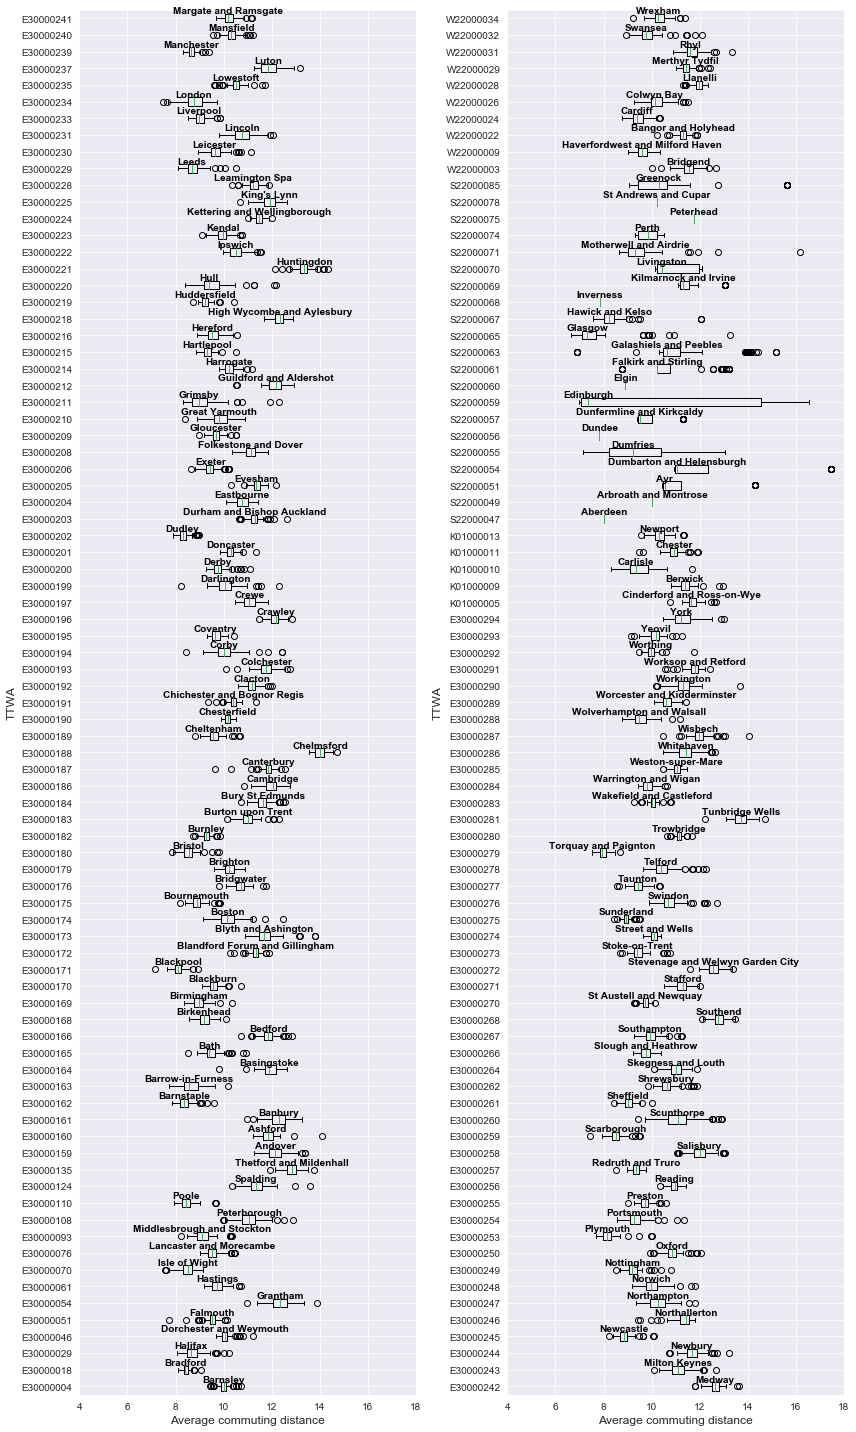

In [49]:
# plot for first half of the TTWAs
inds_plot = range(0,len(inds_ttwa)//2)
fig = plt.figure(figsize= (12,20))
fig.add_subplot(1,2,1)
ttwa_labels= [all_ttwas[ii] for ii in inds_ttwa[inds_plot]]
ttwa_names_plot = [ttwa_data['ttwa11nm'][ttwa_data.index==t].values[0] for t in ttwa_labels]
mask = ~np.isnan(M_dist[:,inds_plot])
filtered_data = [d[m] for d, m in zip(M_dist[:,inds_plot].T, mask.T)]
ax = plt.boxplot(filtered_data, vert = 0, labels = ttwa_labels)
#locs, labels = plt.yticks() 
#plt.yticks(locs, ttwa_labels, fontsize = 12) #, rotation = 'vertical')
plt.ylabel('TTWA', fontsize = 12)
tmp = plt.xlabel('Average commuting distance', fontsize = 12)
# add text 
pos = range(len(inds_ttwa)//2)
for label,tick in zip(pos,ax['medians']):
    plt.text(tick.get_xdata()[0], tick.get_ydata()[1] + 0.03, ttwa_names_plot[label],
            horizontalalignment='center',  color='k', weight='semibold') #size='x-small',
plt.xlim([4,18])
plt.tight_layout()
#if FIGSAVE:
#    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_acrossSOC_by_TTWA_{}pt1.png'.format(ni_qual)),
#               bbox_inches = 'tight', dpi = 300, quality = 95)
    
#second half
inds_plot = range(len(inds_ttwa)//2,len(inds_ttwa))
fig.add_subplot(1,2,2)
ttwa_labels= [all_ttwas[ii] for ii in inds_ttwa[inds_plot]]
ttwa_names_plot = [ttwa_data['ttwa11nm'][ttwa_data.index==t].values[0] for t in ttwa_labels]
mask = ~np.isnan(M_dist[:,inds_plot])
filtered_data = [d[m] for d, m in zip(M_dist[:,inds_plot].T, mask.T)]
ax = plt.boxplot(filtered_data, vert = 0, labels = ttwa_labels)
#locs, labels = plt.yticks() 
#plt.yticks(locs, [all_ttwas[ii] for ii in inds_ttwa[inds_plot]], fontsize = 12) #, rotation = 'vertical')
plt.ylabel('TTWA', fontsize = 12)
tmp = plt.xlabel('Average commuting distance', fontsize = 12)
# add text 
pos = range(len(inds_ttwa)//2)
for label,tick in zip(pos,ax['medians']):
    plt.text(tick.get_xdata()[0], tick.get_ydata()[1] + 0.03, ttwa_names_plot[label],
            horizontalalignment='center',  color='k', weight='semibold') #size='x-small',
plt.xlim([4,18])
plt.tight_layout()
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_acrossSOC_by_TTWA_{}pt2.png'.format(ni_qual)),
               bbox_inches = 'tight', dpi = 300, quality = 95)

In [20]:
'''
# plot a quarter/third of the TTWAs
inds_plot = range(90,135)
fig = plt.figure(figsize= (16,4))
plt.boxplot(M_dist[:,inds_plot])
locs, labels = plt.xticks() 
plt.xticks(locs, [all_ttwas[ii] for ii in inds_ttwa[inds_plot]], fontsize = 12, rotation = 'vertical')
plt.xlabel('TTWA', fontsize = 12)
tmp = plt.ylabel('Average commuting distance', fontsize = 12)
'''
print('Not needed if excluding small TTWAs')

Not needed if excluding small TTWAs


In [21]:
# Add mean distance across TTWAs to ttwa info dataframes
t0 = time.time()
ttwa_info11['mean_distance'] = np.nan
for row in ttwa_info11.index:
    if row in all_ttwas:
        ix = all_ttwas.index(row)
        ttwa_info11['mean_distance'].loc[row] = M_dist_ttwa[ix] #np.nanmean(M_dist[:,ix])
        if np.isnan(np.mean(M_dist[:,ix])):
            print(row, ' is NAN.')
    else:
        continue
#ttwa_info11['mean_distance'] = np.mean(M_dist, axis = 0)
ttwa_info16['mean_distance'] = ttwa_info11['mean_distance']
print_elapsed(t0,'joining mean distances and summary statistics')



/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



S22000047  is NAN.
S22000049  is NAN.
S22000051  is NAN.
S22000054  is NAN.
S22000055  is NAN.
S22000056  is NAN.
S22000057  is NAN.
S22000059  is NAN.
S22000060  is NAN.
S22000061  is NAN.
S22000063  is NAN.
S22000065  is NAN.
S22000067  is NAN.
S22000068  is NAN.
S22000069  is NAN.
S22000070  is NAN.
S22000071  is NAN.
S22000074  is NAN.
S22000075  is NAN.
S22000078  is NAN.
S22000085  is NAN.
Time spent on joining mean distances and summary statistics is 12.285s


In [22]:
print(plt.style.available)


['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


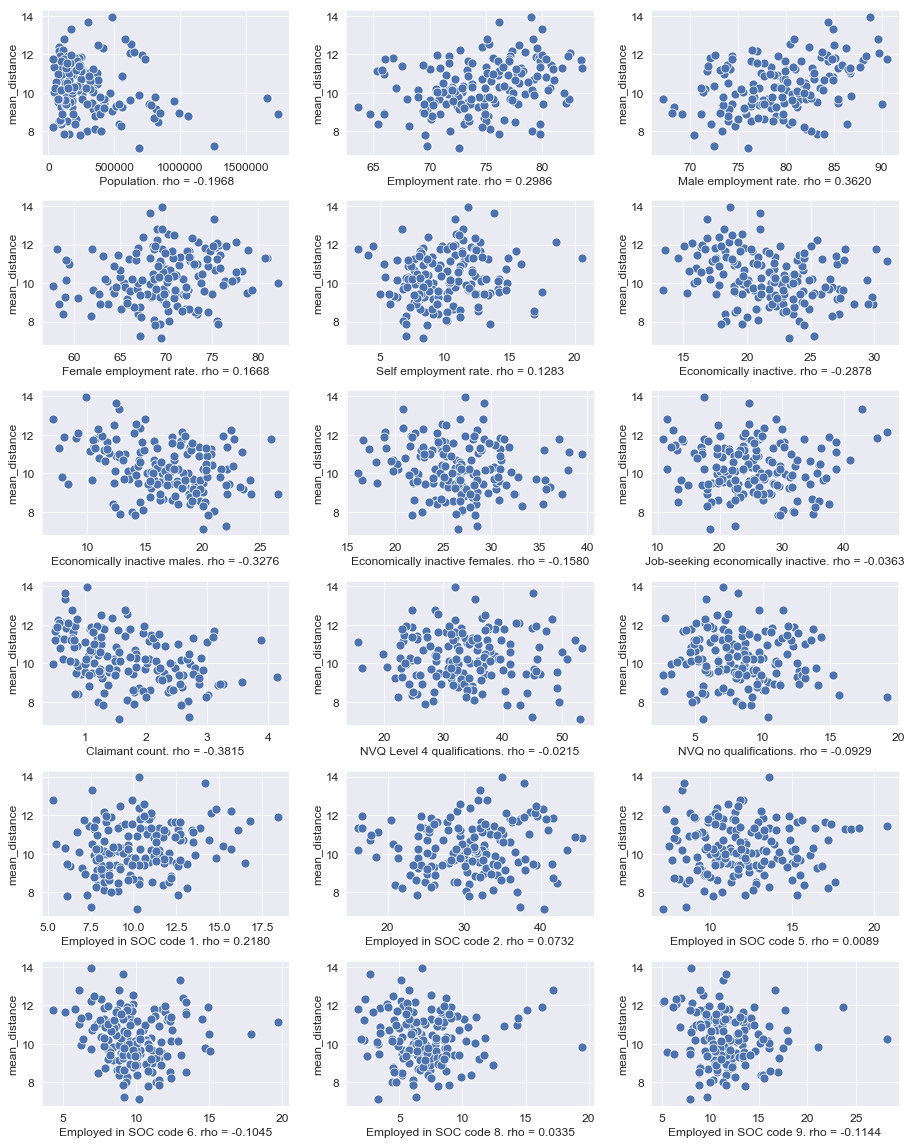

In [48]:
def remove_london(x):
    try:
        if x > 2000000:
            return np.nan
        else:
            return x
    except:
        return x

# plot all correlations between means and the other variables
plt.style.use('seaborn-deep')
ttwa_info16 = ttwa_info16.replace('!',np.nan)
fig, ax = plt.subplots(6,3,figsize=(13,16))
for t,col in enumerate(ttwa_info16.columns[2:20]):
    with sns.plotting_context('talk'):
        i,j = np.unravel_index(t,(6,3))
        #ttwa_info16.plot.scatter(y = 'mean_distance',x = col, ax = ax[i,j])
        sns.scatterplot(data=ttwa_info16.applymap(remove_london),y = 'mean_distance',x = col, ax = ax[i,j])
        rho = ttwa_info16['mean_distance'].corr(ttwa_info16[col])
        ax[i,j].set_xlabel(col + '. rho = {:.4f}'.format(rho), fontsize = 12)
        ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontsize = 12)
        ax[i,j].tick_params(axis = 'both', labelsize = 12)
plt.tight_layout()

if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_vs_ttwa_{}stats16.png'.format(ni_qual)),
               bbox_inches = 'tight', dpi = 300, quality = 95)


In [30]:
main_col16 = ['Male employment rate', 'Female employment rate','Claimant count',
              ' Population','Employed in SOC code 1','Employed in SOC code 9']
main_col11 = ['Supply-side self-containment', 'Demand-side self containment',
       'Land Area (hectares)']

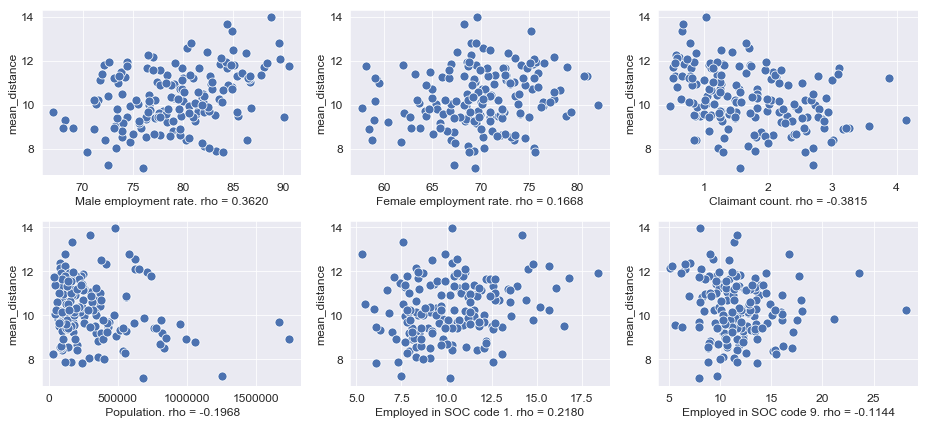

In [47]:

# redo: plot all correlations between means and the other variables
plt.style.use('seaborn-deep')
ttwa_info16 = ttwa_info16.replace('!',np.nan)
fig, ax = plt.subplots(2,3,figsize=(13,6))
for t,col in enumerate(main_col16):
    with sns.plotting_context('talk'):
        i,j = np.unravel_index(t,(2,3))
        #ttwa_info16.plot.scatter(y = 'mean_distance',x = col, ax = ax[i,j])
        sns.scatterplot(data=ttwa_info16.applymap(remove_london),y = 'mean_distance',x = col, ax = ax[i,j])
        rho = ttwa_info16['mean_distance'].corr(ttwa_info16[col])
        ax[i,j].set_xlabel(col + '. rho = {:.4f}'.format(rho), fontsize = 12)
        ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontsize = 12)
        ax[i,j].tick_params(axis = 'both', labelsize = 12)
plt.tight_layout()

if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_vs_ttwa_{}stats16_select.png'.format(ni_qual)),
               bbox_inches = 'tight', dpi = 300, quality = 95)


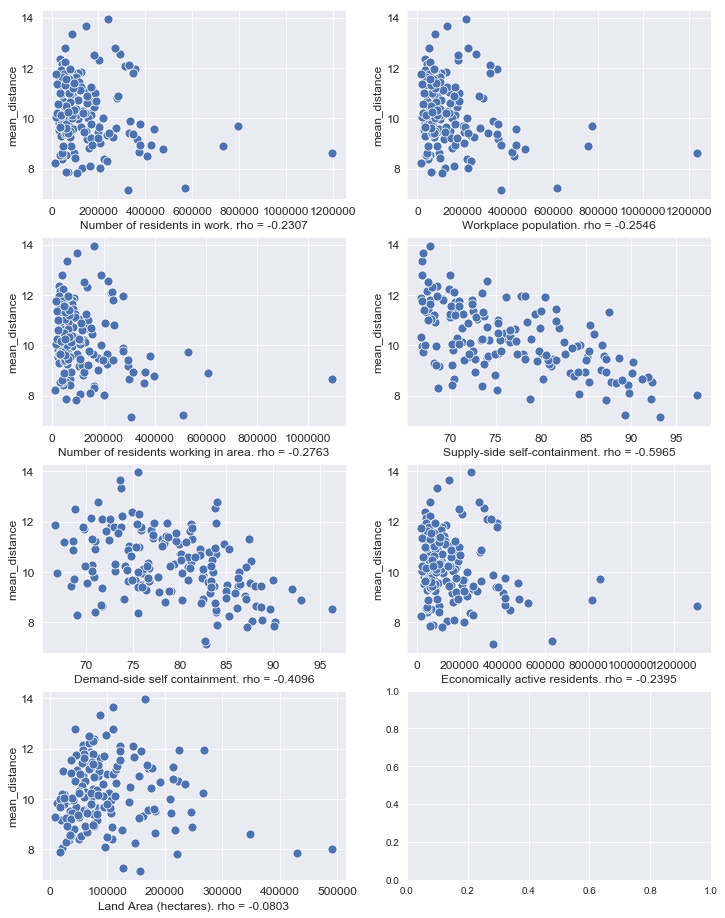

In [46]:
# plot all correlations between means and the other variables

ttwa_info11 = ttwa_info11.replace('!',np.nan)
fig, ax = plt.subplots(4,2,figsize=(12,16))
for t,col in enumerate(ttwa_info11.columns[2:9]):
    with sns.plotting_context('talk'):
        i,j = np.unravel_index(t,(4,2))
        ttwa_info11['tmp'] = ttwa_info11[col]
        ttwa_info11['tmp'] = ttwa_info11['tmp'].map(remove_london)
        sns.scatterplot(data=ttwa_info11,y = 'mean_distance',x = 'tmp', ax = ax[i,j])
        rho = ttwa_info11['mean_distance'].corr(ttwa_info11['tmp'])
        ax[i,j].set_xlabel(col + '. rho = {:.4f}'.format(rho), fontsize = 12)
        ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontsize = 12)
        ax[i,j].tick_params(axis = 'both', labelsize = 12)
plt.tight_layout
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_vs_ttwa_{}stats11.png'.format(ni_qual)),
               bbox_inches = 'tight', dpi = 300, quality = 95)

            ttwa11nm  mean_distance
ttwa11cd                           
E30000234     London       8.752968
S22000047   Aberdeen       8.013038
S22000055   Dumfries       8.612014
S22000056     Dundee       7.823322
S22000068  Inverness       7.854617


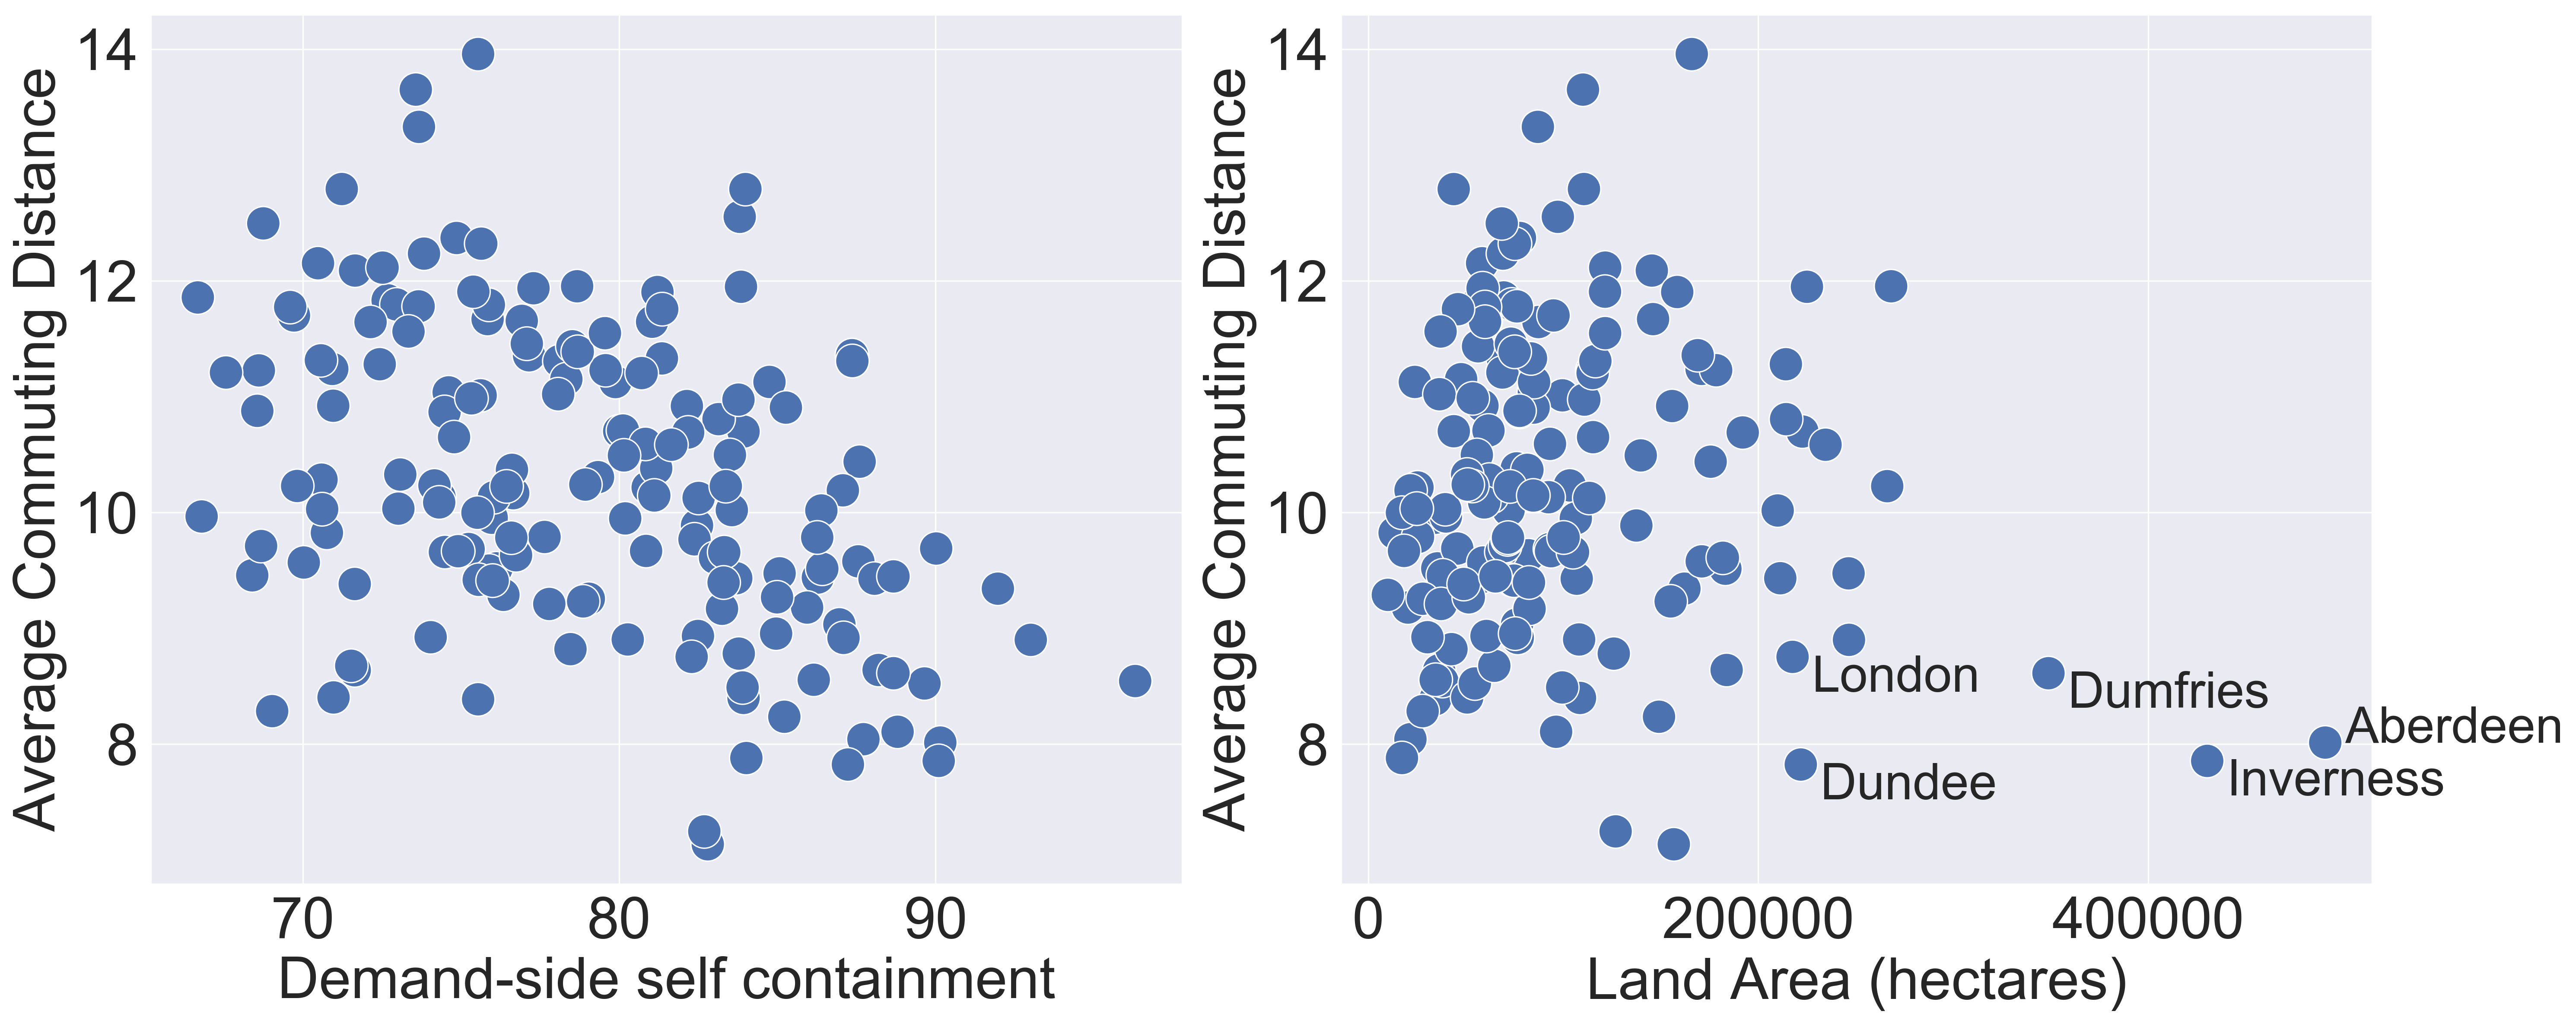

In [123]:
# redo: plot all correlations between means and the other variables for selected columns

# take the ones that have large area, but still with short distances
ttwa_good = ttwa_info11[(ttwa_info11['Land Area (hectares)']>200000) & 
                                    (ttwa_info11['mean_distance']<8.8)]
print(ttwa_good[['ttwa11nm','mean_distance']])

ttwa_info11 = ttwa_info11.replace('!',np.nan)
fig, ax = plt.subplots(1,2,figsize=(20,8), dpi = 300)
for t,col in enumerate(main_col11[1:]):
    with sns.plotting_context('talk'):
        i,j = np.unravel_index(t,(1,2))
        ttwa_info11['tmp'] = ttwa_info11[col]
        ttwa_info11['tmp'] = ttwa_info11['tmp']#.map(remove_london)
        sns.scatterplot(data=ttwa_info11,y = 'mean_distance',x = 'tmp', ax = ax[j], size = 1, sizes = (350,350),
                       legend = False)
        rho = ttwa_info11['mean_distance'].corr(ttwa_info11['tmp'])
        ax[j].set_xlabel(col, fontsize = 32, fontname="Arial")# + '. rho = {:.4f}'.format(rho), fontsize = 26)
        ax[j].set_ylabel('Average Commuting Distance', fontsize = 32, fontname="Arial")
        ax[j].tick_params(axis = 'both', labelsize = 32)
        if col == 'Economically active residents':
            ax[j].tick_params(axis = 'x', labelsize = 32, labelrotation = 45)
        for tick in ax[j].get_xticklabels():
            tick.set_fontname("Arial")
        for tick in ax[j].get_yticklabels():
            tick.set_fontname("Arial")
        # add labels
        if col == 'Land Area (hectares)':
            for ttwa in ttwa_good.index:
                if ttwa_info11['ttwa11nm'].loc[ttwa] == 'Aberdeen':
                    plt.text(ttwa_info11['tmp'].loc[ttwa]+10000,ttwa_info11['mean_distance'].loc[ttwa],
                        ttwa_info11['ttwa11nm'].loc[ttwa], fontsize = 28, fontname="Arial")#, axis = ax[j])
                else:
                    plt.text(ttwa_info11['tmp'].loc[ttwa]+10000,ttwa_info11['mean_distance'].loc[ttwa]-.3,
                        ttwa_info11['ttwa11nm'].loc[ttwa], fontsize = 28, fontname="Arial")#, axis = ax[j])
plt.tight_layout()
if FIGSAVE or True:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_vs_ttwa_{}stats11_select.png'.format(ni_qual)),
               bbox_inches = 'tight',dpi = 300, quality = 95)


In [93]:
print(list(ttwa_data['ttwa11nm']))

['Barnsley', 'Bradford', 'Halifax', 'Dorchester and Weymouth', 'Falmouth', 'Grantham', 'Hastings', 'Isle of Wight', 'Lancaster and Morecambe', 'Middlesbrough and Stockton', 'Peterborough', 'Poole', 'Spalding', 'Thetford and Mildenhall', 'Andover', 'Ashford', 'Banbury', 'Barnstaple', 'Barrow-in-Furness', 'Basingstoke', 'Bath', 'Bedford', 'Birkenhead', 'Birmingham', 'Blackburn', 'Blackpool', 'Blandford Forum and Gillingham', 'Blyth and Ashington', 'Boston', 'Bournemouth', 'Bridgwater', 'Brighton', 'Bristol', 'Burnley', 'Burton upon Trent', 'Bury St Edmunds', 'Cambridge', 'Canterbury', 'Chelmsford', 'Cheltenham', 'Chesterfield', 'Chichester and Bognor Regis', 'Clacton', 'Colchester', 'Corby', 'Coventry', 'Crawley', 'Crewe', 'Darlington', 'Derby', 'Doncaster', 'Dudley', 'Durham and Bishop Auckland', 'Eastbourne', 'Evesham', 'Exeter', 'Folkestone and Dover', 'Gloucester', 'Great Yarmouth', 'Grimsby', 'Guildford and Aldershot', 'Harrogate', 'Hartlepool', 'Hereford', 'High Wycombe and Aylesbu

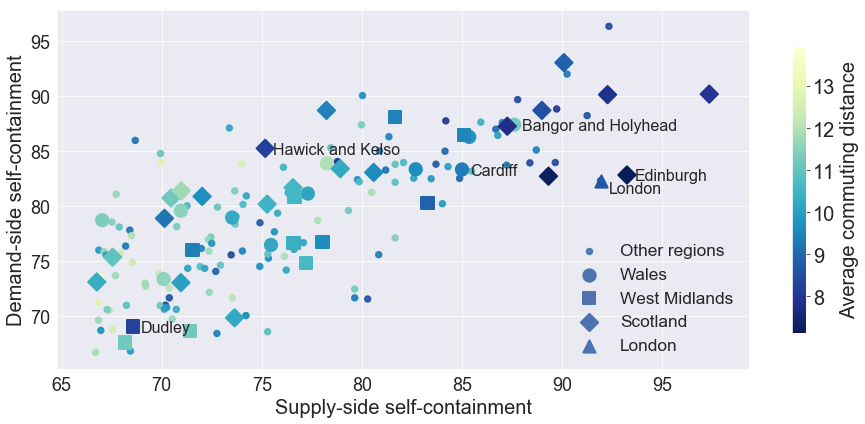

In [126]:
fig = plt.figure(figsize = (13,6))
#g = sns.scatterplot(x='Supply-side self-containment',y='Demand-side self containment',
#               hue = 'mean_distance', data= ttwa_info11, sizes = [20], 
#                palette = 'YlGnBu_r', s = 80)
cmin = np.min(ttwa_info11['mean_distance'])
cmax = np.max(ttwa_info11['mean_distance'])
with sns.axes_style('darkgrid'):
    markerlist = ['o','s','D','^']
    plt.scatter(ttwa_info11['Supply-side self-containment'], ttwa_info11['Demand-side self containment'], 
                              marker = '.',alpha = 0.9,c=ttwa_info11['mean_distance'], s =120,
                               cmap = 'YlGnBu_r', vmin= cmin, vmax = cmax, linewidth = 2)
    for ir, region in enumerate(['Wales','West Midlands', 'Scotland','London']):
        plt.scatter(ttwa_info11['Supply-side self-containment'][ttwa_info16['Region/Country']==region], 
                    ttwa_info11['Demand-side self containment'][ttwa_info16['Region/Country']==region], 
                    c=ttwa_info11['mean_distance'][ttwa_info16['Region/Country']==region], 
                    marker=markerlist[ir], cmap='YlGnBu_r', s= 150, linewidth = 2, vmin= cmin, vmax = cmax)
                              #, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, 
                                #verts=None, edgecolors=None)
    ax = plt.gca()
    ax.set_ylabel('Demand-side self-containment',fontsize = 20, fontname= 'Arial')
    ax.set_xlabel('Supply-side self-containment',fontsize = 20, fontname = 'Arial')
    ax.tick_params(axis = 'both', labelsize = 18)
    cb = plt.colorbar(shrink = 0.8)
    hl = plt.legend(('Other regions','Wales','West Midlands', 'Scotland','London'), loc = 4, fontsize = 'xx-large',
                   frameon = False)
    plt.setp(hl.texts, family='Arial')
    cb.set_label('Average commuting distance', size = 20)
    cb.ax.tick_params(labelsize=20)
    plt.tight_layout()
    
    ttwa_list = ['Edinburgh','Dudley','Cardiff','London','Hawick and Kelso','Bangor and Holyhead']
    for ttwa in ttwa_list:
        ix = ttwa_info11['ttwa11nm']==ttwa
        x = ttwa_info11['Supply-side self-containment'][ix]
        y = ttwa_info11['Demand-side self containment'][ix]
        if ttwa=='London':
            plt.text(x+.4,y-1.1,ttwa, fontsize = 16, fontname = 'Arial')
        else:
            plt.text(x+.4,y-.5,ttwa, fontsize = 16, fontname = 'Arial')
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'demand_vs_supply_by_regions_{}static.png'.format(ni_qual)),
               bbox_inches = 'tight', dpi = 300, quality = 95)

In [36]:
# plot same plot as above but interactive
reload(plotly)
PuOr = sns.color_palette(palette= 'PuOr', n_colors = 256)

fig = {
    'data': [
          {
          'x': ttwa_info11['Supply-side self-containment'], 
            'y': ttwa_info11['Demand-side self containment'], 
            'text': ttwa_info11['ttwa11nm'], 
            'mode': 'markers', 
            'name': 'Demand vs Supply',
            'marker': dict(
                size=16,
                color = ttwa_info11['mean_distance'], #set color equal to a variable
                colorscale='YlGnBu',
                showscale=True
                )
          },
    ],
    'layout': {
        'xaxis': {'title': 'Supply-side self-containment'},
        'yaxis': {'title': "Demand-side self-containment"}
    }
}
plotly.offline.iplot(fig, filename = os.path.join(plot_save_dir,'demand_vs_supply_{}interactive.html'.format(
    ni_qual)))
if FIGSAVE:
    plotly.offline.plot(fig, filename = os.path.join(plot_save_dir,'demand_vs_supply_{}interactive.html'.format(
        ni_qual)), auto_open = False)
                #, image = 'png', image_filename = os.path.join(plot_save_dir,'demand_vs_supply_interactive.html'))
#plotly.io.write_image(fig, file = os.path.join(plot_save_dir,'demand_vs_supply_interactive.png'))
#py.iplot(fig, filename='pandas-multiple-scatter')

In [37]:
show_cols = ['ttwa11nm','Region/Country', ' Population', 'Employment rate','Economically inactive',
             'Job-seeking economically inactive',
             'Employed in SOC code 1',
            'Employed in SOC code 1','mean_distance']
#for col in show_cols[1:]:
#    print(ttwa_info16[col].mean())
    # need to change a few strings to nans
print('The averages for each column are:')
print([(col, ttwa_info16[col].mean()) for col in show_cols[2:]])
print('\n')
print('The 10 TTWA with the shortest distance are: ')
ttwa_info16[show_cols].sort_values('mean_distance')[:10]



The averages for each column are:
[(' Population', 368750.1445783133), ('Employment rate', 74.55240963855422), ('Economically inactive', 21.59819277108434), ('Job-seeking economically inactive', 25.212727272727275), ('Employed in SOC code 1', 10.268072289156626), ('Employed in SOC code 1', 10.268072289156626), ('mean_distance', 10.271545428810143)]


The 10 TTWA with the shortest distance are: 


ttwa11nm Region/Country   Population  Employment rate  \
ttwa11cd                                                                       
S22000059             Edinburgh       Scotland     685057.0             72.6   
S22000065               Glasgow       Scotland    1256435.0             69.8   
S22000056                Dundee       Scotland     240820.0             69.6   
S22000068             Inverness       Scotland     117914.0             79.8   
E30000279  Torquay and Paignton     South West     158111.0             76.2   
S22000047              Aberdeen       Scotland     397285.0             79.1   
E30000171             Blackpool     North West     290955.0             71.8   
E30000253              Plymouth     South West     354811.0             75.4   
S22000067      Hawick and Kelso       Scotland      34169.0             74.7   
E30000202                Dudley  West Midlands     548492.0             68.2   

           Economically inactive  Job-seeking economically inactive  \
ttwa11cd                                                              
S22000059                   23.3                               18.5   
S22000065                   25.3                               22.4   
S22000056                   24.5                               29.4   
S22000068                   18.0                               29.8   
E30000279                   19.6                               35.0   
S22000047                   18.4                               32.0   
E30000171                   24.1                               31.8   
E30000253                   20.9                               30.2   
S22000067                   20.0                               35.4   
E30000202                   26.7                               18.0   

           Employed in SOC code 1  Employed in SOC code 1  mean_distance  
ttwa11cd                                                                  
S22000059                    10.2                    10.2       7.134554  
S22000065                     7.5                     7.5       7.245998  
S22000056                     6.1                     6.1       7.823322  
S22000068                     7.3                     7.3       7.854617  
E30000279                    12.6                    12.6       7.879394  
S22000047                     8.7                     8.7       8.013038  
E30000171                     9.1                     9.1       8.042129  
E30000253                     8.3                     8.3       8.106317  
S22000067                    13.1                    13.1       8.235996  
E30000202                     7.8                     7.8       8.284534

In [38]:
print('The 10 TTWA with the highest distance are: ')
ttwa_info16[show_cols].sort_values('mean_distance')[-10:]


The 10 TTWA with the highest distance are: 


ttwa11nm   Region/Country   Population  \
ttwa11cd                                                                    
E30000161                           Banbury    East Midlands     114722.0   
E30000218        High Wycombe and Aylesbury       South East     412054.0   
E30000054                          Grantham    East Midlands      78556.0   
E30000272  Stevenage and Welwyn Garden City  East of England     375958.0   
E30000242                            Medway       South East     626275.0   
E30000268                          Southend  East of England     581668.0   
E30000135           Thetford and Mildenhall  East of England     118112.0   
E30000221                        Huntingdon  East of England     170897.0   
E30000281                   Tunbridge Wells       South East     298834.0   
E30000188                        Chelmsford  East of England     482688.0   

           Employment rate  Economically inactive  \
ttwa11cd                                            
E30000161             72.7                   25.5   
E30000218             79.6                   16.9   
E30000054             74.7                   17.8   
E30000272             78.0                   18.8   
E30000242             75.3                   19.6   
E30000268             75.1                   21.0   
E30000135             79.2                   18.2   
E30000221             80.0                   16.9   
E30000281             76.2                   21.0   
E30000188             79.0                   18.7   

           Job-seeking economically inactive  Employed in SOC code 1  \
ttwa11cd                                                               
E30000161                               12.5                    15.7   
E30000218                               30.1                    14.8   
E30000054                               27.2                    10.3   
E30000272                               19.7                     9.2   
E30000242                               24.7                    10.6   
E30000268                               29.0                     9.9   
E30000135                               11.5                     5.3   
E30000221                               43.0                     7.6   
E30000281                               24.7                    14.2   
E30000188                               17.4                    10.3   

           Employed in SOC code 1  mean_distance  
ttwa11cd                                          
E30000161                    15.7      12.235796  
E30000218                    14.8      12.321730  
E30000054                    10.3      12.370585  
E30000272                     9.2      12.496728  
E30000242                    10.6      12.553398  
E30000268                     9.9      12.793119  
E30000135                     5.3      12.793514  
E30000221                     7.6      13.330086  
E30000281                    14.2      13.652056  
E30000188                    10.3      13.959100

In [39]:
def assign_score(x):
    if x['best']:
        return 'Shortest'
    elif x['worst']: #TTWA'] in highest_distance_ttwas:
        return 'Longest'
    else:
        return 'Average'
    
def assign_region(row,ttwa_info):
    region = ttwa_info['Region/Country'].loc[row['TTWA']]
    return region

In [40]:
tmp = ttwa_info16.sort_values('mean_distance')['mean_distance'].values
p = np.percentile(ttwa_info16['mean_distance'].values, 20)
np.sum(tmp<p)/tmp.size
N = int(np.round(len(ttwa_info16)/4))
print(N)

42


In [41]:
# now get the lowest and highest 25th percentile - that is take the bottom and top quarter
N = int(np.round(len(ttwa_info16)/4))
shortest_distance_ttwas = ttwa_info16.sort_values('mean_distance')[:N]['ttwa11nm'].values
shortest_distance_codes = ttwa_info16.sort_values('mean_distance').index[:N].values
highest_distance_ttwas = ttwa_info16[show_cols].sort_values('mean_distance')[-N:]['ttwa11nm'].values
highest_distance_codes = ttwa_info16[show_cols].sort_values('mean_distance').index[-N:].values

In [42]:
# add best and worst indicator to ttwa_info11 and ttwa_info16 too
ttwa_info11 = ttwa_info11.assign(best = [t in shortest_distance_codes for t in ttwa_info11.index])
ttwa_info11 = ttwa_info11.assign(worst = [t in highest_distance_codes for t in ttwa_info11.index])
ttwa_info11['Rank'] = ttwa_info11.apply(assign_score, axis = 1)
# ttwa_info16
#ttwa_info16['best'] = ttwa_info16.reset_index()['ttwa11cd'].apply(lambda x: x in shortest_distance_codes)
ttwa_info16 = ttwa_info16.assign(best = [t in shortest_distance_codes for t in ttwa_info16.index])
ttwa_info16 = ttwa_info16.assign(worst = [t in highest_distance_codes for t in ttwa_info16.index])
ttwa_info16['Rank'] = ttwa_info16.apply(assign_score, axis = 1)
print('Done')

Done


In [43]:
# transform the data into a dataframe. The column that stores the TTWA codes is called TTWA
t0 = time.time()
select_ttwa = [all_ttwas[ii] for ii in inds_ttwa]

# now turn the nan values into the average for that ttwa
# Find indices that are NaN
M_dist_bkp = copy.deepcopy(M_dist)
inds = np.where(np.isnan(M_dist))
# Place column means in the indices. Align the arrays using take
M_dist[inds] = np.take(col_mean, inds[1])

select_ttwa_names = [ttwa_data['ttwa11nm'][ttwa_data.index==t].values[0] for t in select_ttwa]
distances_data = pd.DataFrame(M_dist.T, index = select_ttwa, 
                    columns = all_occupations)
distances_data['TTWA'] = distances_data.index
distances_data['TTWA name'] = ttwa_info11['ttwa11nm']

# make a copy of the dataframe wide form
distances_data_wide = copy.deepcopy(distances_data)
distances_data_wide['Region'] = distances_data_wide['TTWA'].apply(lambda x: ttwa_info16['Region/Country'].loc[x])

# transform the dataframe into a long form
distances_data = distances_data.melt(id_vars = ['TTWA','TTWA name'], var_name = ['Occupation code'],
                                    value_name = 'Mean distance')
distances_data['Occupation first digit'] = distances_data['Occupation code'].apply(lambda x: x[0])
distances_data['best'] = distances_data['TTWA'].apply(lambda x: x in shortest_distance_codes)
distances_data['worst'] = distances_data['TTWA'].apply(lambda x: x in highest_distance_codes)
distances_data['Rank'] = distances_data.apply(assign_score, axis = 1)
distances_data['Region'] = distances_data.apply(lambda x: assign_region(x, ttwa_info16), axis = 1)
#distances_data['ttwa'].value_counts()
#len(all_occupations)
print(time.time() - t0, len(distances_data))
distances_data.head(n=3)


1.3097150325775146 14774


TTWA TTWA name Occupation code  Mean distance Occupation first digit  \
0  E30000004  Barnsley             350      10.069324                      3   
1  E30000018  Bradford             350       8.548257                      3   
2  E30000029   Halifax             350       8.727511                      3   

    best  worst      Rank                    Region  
0  False  False   Average  Yorkshire and The Humber  
1   True  False  Shortest  Yorkshire and The Humber  
2   True  False  Shortest  Yorkshire and The Humber

South West                  25.0
South East                  24.0
Scotland                    21.0
East Midlands               18.0
East of England             17.0
North West                  16.0
Yorkshire and The Humber    14.0
West Midlands               11.0
Wales                       11.0
North East                   8.0
London                       1.0
Name: Region, dtype: float64


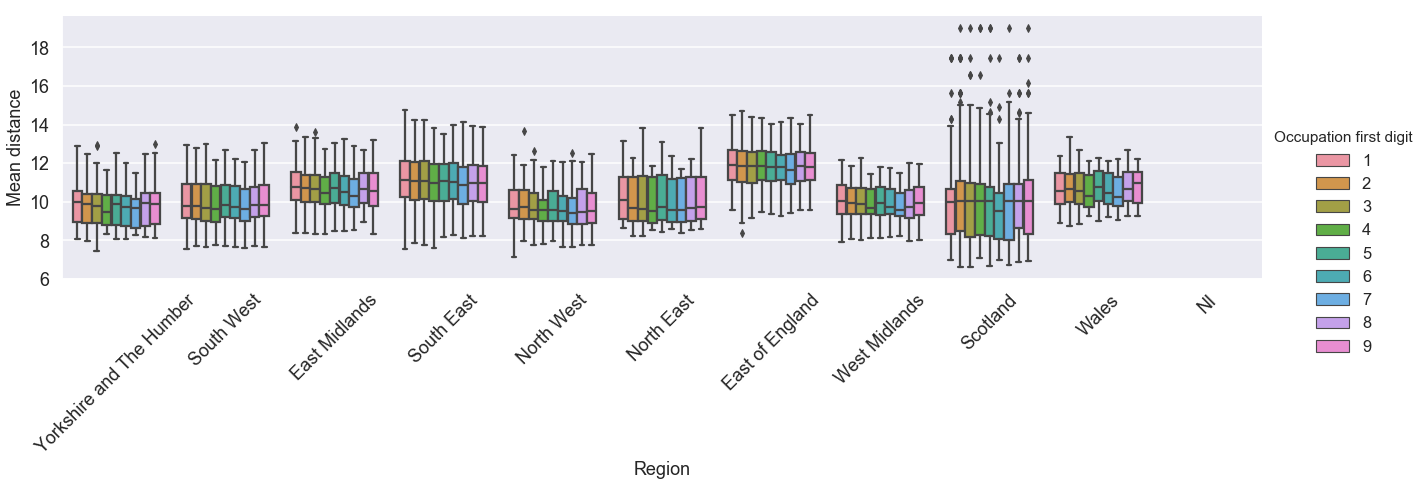

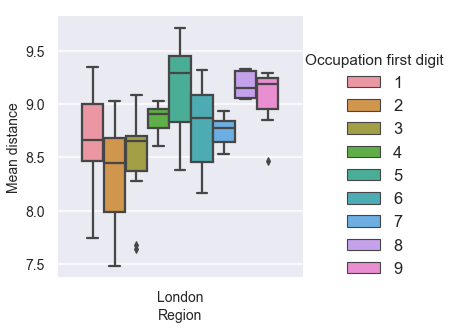

In [50]:
# plot breakdown of average commuting distances by SOC code (first digit) and regions
plt.style.use('seaborn-deep')

with sns.plotting_context('talk'):
    g = sns.catplot(data = distances_data, y = 'Mean distance', x = 'Region', hue = 'Occupation first digit', 
                    kind = 'box', height = 5, aspect = 18/5, order = ['Yorkshire and The Humber', 'South West', 
                    'East Midlands', 'South East','North West','North East','East of England',
                    'West Midlands','Scotland','Wales','NI'], legend_out = True)
    plt.gca().tick_params(axis = 'x', labelrotation = 45)
    ax = plt.gca()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(18)

#plt.tight_layout()
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_region_and_1d-SOC-workers.png'),
                bbox_inches = 'tight')
    
with sns.plotting_context('talk'):
    g = sns.catplot(data = distances_data, y = 'Mean distance', x = 'Region', hue = 'Occupation first digit', 
                    kind = 'box', height = 5, aspect = 1, order = ['London'], legend_out = True)
    ax = plt.gca()
    for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_london_and_1d-SOC-workers_{}.png'.format(ni_qual)),
                bbox_inches = 'tight', dpi = 300, quality = 95)

print(distances_data['Region'].value_counts()/len(all_occupations))

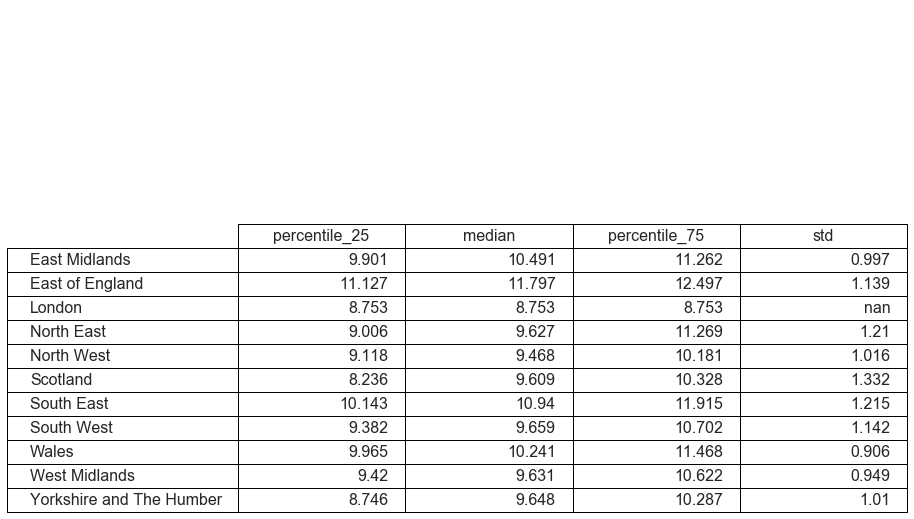

In [51]:
def mypercentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:2.0f}'.format(n*100)
    return percentile_

# collect some stats for each region
#tmp = distances_data.groupby('Region')['Mean distance'].aggregate([
#    mypercentile(.25), np.median, mypercentile(.75),np.std])
#tmp = tmp.applymap(lambda x: np.around(x,3))

tmp = ttwa_info16.groupby('Region/Country')['mean_distance'].aggregate([
    mypercentile(.25), np.median, mypercentile(.75),np.std])
tmp = tmp.applymap(lambda x: np.around(x,3))

# prepare to plot the table: make the rest of the plot invisible
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

# make the table and make it bigger
Tab = table(ax, tmp, fontsize= 16)
Tab.scale(2,2)
Tab.set_fontsize(16)
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_region_stats_{}noSOC.png'.format(ni_qual)),
                bbox_inches = 'tight', dpi = 300, quality = 95)

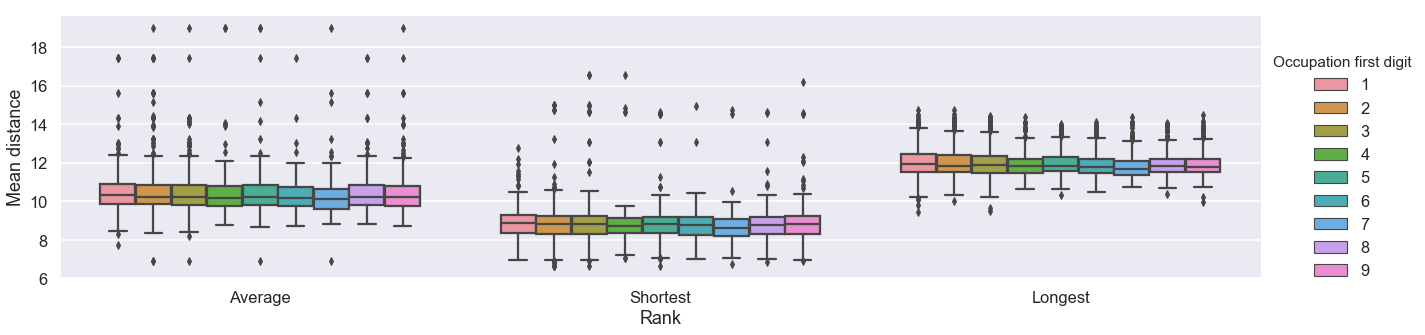

In [52]:
with sns.plotting_context('talk'):
    g = sns.catplot(data = distances_data, y = 'Mean distance', x = 'Rank', hue = 'Occupation first digit', 
                    kind = 'box', height = 5, aspect = 18/5)
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_ranking_and_1d-SOC-workers_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

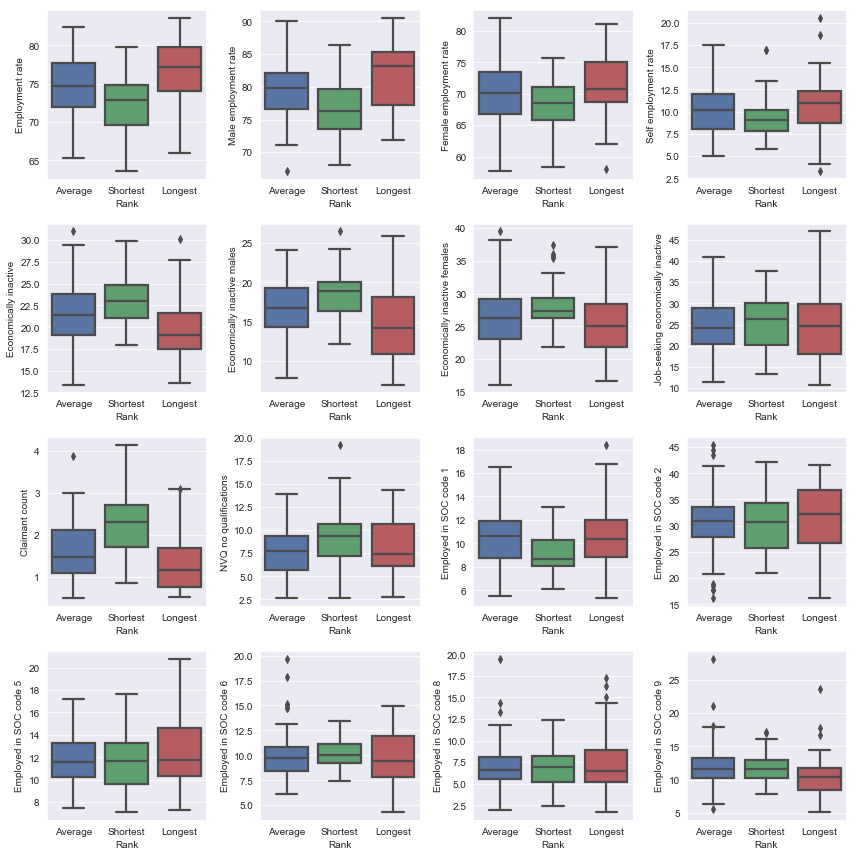

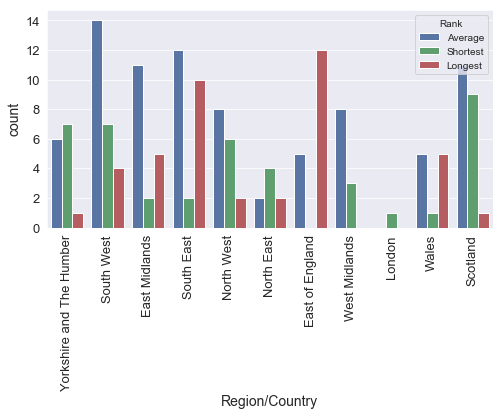

In [53]:
# try plotting various indicators still comparing by best - worst - average TTWA
fig, ax = plt.subplots(4,4,figsize=(12,12))
with sns.plotting_context('talk', font_scale = 3):
    for t,col in enumerate(list(ttwa_info16.columns[3:12])+list(ttwa_info16.columns[13:20])):
        i,j = np.unravel_index(t,(4,4))
        g = sns.boxplot(data = ttwa_info16, y = col, x = 'Rank', ax = ax[i,j]) 
                    #kind = 'box', height = 4, aspect = 1.2)
        #ttwa_info16.plot.scatter(y = 'mean_distance',x = col, ax = ax[i,j])
        #ax[i,j].set_ylabel(col[0:28])
    # now plot the regions
    i,j = np.unravel_index(t+1,(5,4))
plt.tight_layout()
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_ranking_and_stats16_{}pt1.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)
    
fig = plt.figure(figsize=(8,4))
g = sns.countplot(data = ttwa_info16, x = 'Region/Country', hue = 'Rank')
g.tick_params(axis = 'x', labelrotation = 90)
g.tick_params(axis = 'both', labelsize = 13)
g.set_xlabel(g.get_xlabel(),fontsize = 14)
g.set_ylabel(g.get_ylabel(),fontsize = 14)
plt.tight_layout
'''
with sns.plotting_context('talk'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    sns.boxplot(x='not.fully.paid', y='int.rate', kind='box', data=loans, ax=ax1)
    sns.boxplot(x='not.fully.paid', y='fico', kind='box', data=loans, ax=ax2)
    g = sns.catplot(data = ttwa_info16, y = 'Employment rate ', x = 'order', 
                    kind = 'box', height = 4, aspect = 1.2)
'''
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_ranking_and_stats16_{}pt2.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)
    

In [54]:
# do a 2-samples kolmogorov-smirnoff test to check whether differences are significant
ksres = {}
for t,col in enumerate(main_col16):
    x_a= ttwa_info16[ttwa_info16['Rank']=='Average'][col]
    x_s = ttwa_info16[ttwa_info16['Rank']=='Shortest'][col]
    x_l = ttwa_info16[ttwa_info16['Rank']=='Longest'][col]
    ksres[col] = {}
    ksres[col]['a_vs_s'] = scipy.stats.ks_2samp(x_a, x_s)
    ksres[col]['a_vs_l'] = scipy.stats.ks_2samp(x_a, x_l)
    ksres[col]['l_vs_s'] = scipy.stats.ks_2samp(x_l, x_s)
    print(col,ksres[col])

Male employment rate {'a_vs_s': Ks_2sampResult(statistic=0.35249709639953547, pvalue=0.0013838336257649799), 'a_vs_l': Ks_2sampResult(statistic=0.3414634146341463, pvalue=0.002166755039751221), 'l_vs_s': Ks_2sampResult(statistic=0.45238095238095244, pvalue=0.00021373443935529377)}
Female employment rate {'a_vs_s': Ks_2sampResult(statistic=0.21602787456446, pvalue=0.1300413384002965), 'a_vs_l': Ks_2sampResult(statistic=0.13763066202090596, pvalue=0.6360633137358237), 'l_vs_s': Ks_2sampResult(statistic=0.30952380952380953, pvalue=0.027666616782705013)}
Claimant count {'a_vs_s': Ks_2sampResult(statistic=0.3641114982578398, pvalue=0.0008500014362670535), 'a_vs_l': Ks_2sampResult(statistic=0.26016260162601623, pvalue=0.037994441560780065), 'l_vs_s': Ks_2sampResult(statistic=0.5476190476190477, pvalue=3.032509329516313e-06)}
 Population {'a_vs_s': Ks_2sampResult(statistic=0.3763066202090593, pvalue=0.0005009426337509099), 'a_vs_l': Ks_2sampResult(statistic=0.20441347270615567, pvalue=0.17302

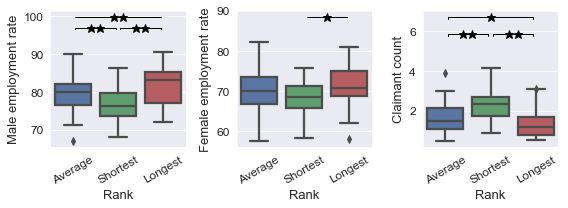

In [127]:
# try plotting various indicators still comparing by best - worst - average TTWA

xlocation = {'a_vs_s': [0,1], 'a_vs_l': [0,2], 'l_vs_s': [1,2]}
ylocation = {'a_vs_s': 5, 'a_vs_l': 8, 'l_vs_s': 5}
fig, ax = plt.subplots(1,3,figsize=(8,3))
with sns.plotting_context('talk', font_scale = 3):
    for t,col in enumerate(main_col16[:3]):
        i,j = np.unravel_index(t,(1,3))
        #g = sns.boxplot(data = ttwa_info16.applymap(remove_london), y = col, x = 'Rank', ax = ax[i,j]) 
        g = sns.boxplot(data = ttwa_info16, y = col, x = 'Rank', ax = ax[j]) 
        ax[j].tick_params(axis = 'x', rotation = 30)
        ax[j].tick_params(axis = 'both', labelsize = 12)
        for tick in ax[j].get_yticklabels():
            tick.set_fontname("Arial")
        for tick in ax[j].get_xticklabels():
            tick.set_fontname("Arial")
        ax[j].set_xlabel(ax[j].get_xlabel(), fontsize = 13, fontname = 'Arial')
        ax[j].set_ylabel(ax[j].get_ylabel(), fontsize = 13, fontname = 'Arial')
        # add asterisks for statistical significance
        alpha = 0.05
        xt = ax[j].get_xticks()
        yt = ax[j].get_ylim()
        for ast in ['a_vs_s','a_vs_l','l_vs_s']:
            if ksres[col][ast][1]<alpha:
                x1 = xlocation[ast][0]+.05
                x2 = xlocation[ast][1]-0.05
                x3 = (x1+x2)/2.
                y1= yt[1]+ (ylocation[ast]*yt[1]/15 if yt[1]<50 else ylocation[ast])
                y2= y1 + .1
                ax[j].plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
                if ksres[col][ast][1]<.01:
                    ax[j].plot(x3-.1,y2,'k*')
                    ax[j].plot(x3+.1,y2,'k*')
                else:
                    ax[j].plot(x3,y2,'k*')
    # now plot the regions
    i,j = np.unravel_index(t+1,(5,4))
plt.tight_layout()
if FIGSAVE or True:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_ranking_and_stats16_{}pt1_select.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)
    

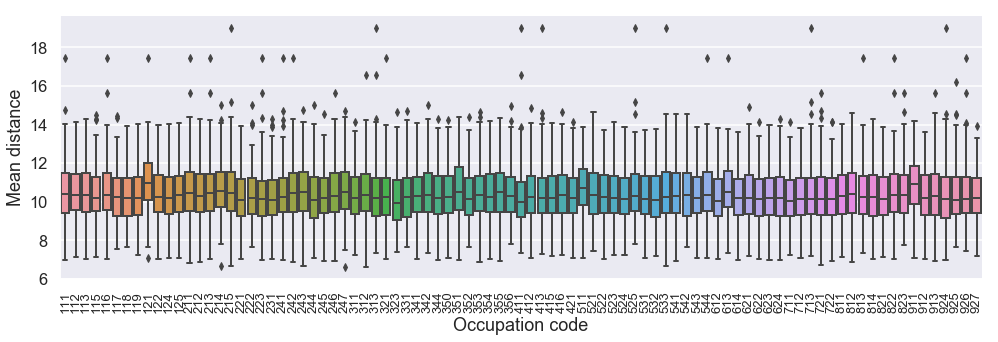

In [56]:
with sns.axes_style('darkgrid'):
    with sns.plotting_context('talk'):
        g = sns.catplot( x = 'Occupation code', y = 'Mean distance', 
                            data = distances_data,
                     linewidth = 2, kind = 'box')
        tmp = g.fig.set_size_inches((18,5))
        plt.gca().set_xticklabels(plt.gca().get_xticklabels(),rotation=90, fontsize = 13)
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_3d-SOC-workers_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

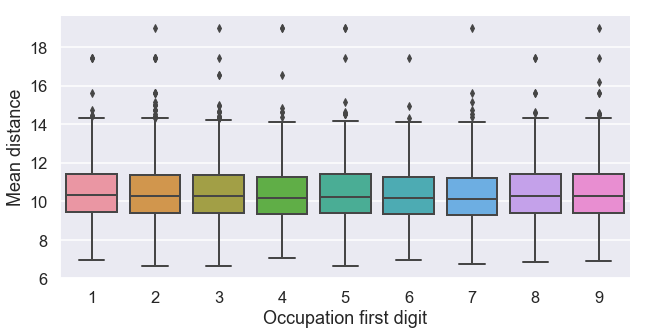

In [57]:
# replot the boxplot for first digit occupations
with sns.axes_style('darkgrid'):
    with sns.plotting_context('talk'):
        g = sns.catplot( x = 'Occupation first digit', y = 'Mean distance', 
                            data = distances_data,
                     linewidth = 2, kind = 'box')
        g.fig.set_size_inches((11,5))
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_by_1d-SOC-workers_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

In [58]:
'''
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu,
GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1,
Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, 
Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, 
Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r,
YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r,cividis,
cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth,
gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, 
gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r,
hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral,
nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, 
rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r,
tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r,
vlag, vlag_r, winter, winter_r
'''
print('all palettes')

all palettes


In [59]:
# for the next plots, I need the TTWA ordered based on their mean
IX_ttwa = np.argsort(np.mean(M_dist, axis = 0))
print(len(IX_ttwa))
ordered_ttwa = [select_ttwa[ii] for ii in IX_ttwa]
ordered_ttwa_names = [select_ttwa_names[ii] for ii in IX_ttwa]

166


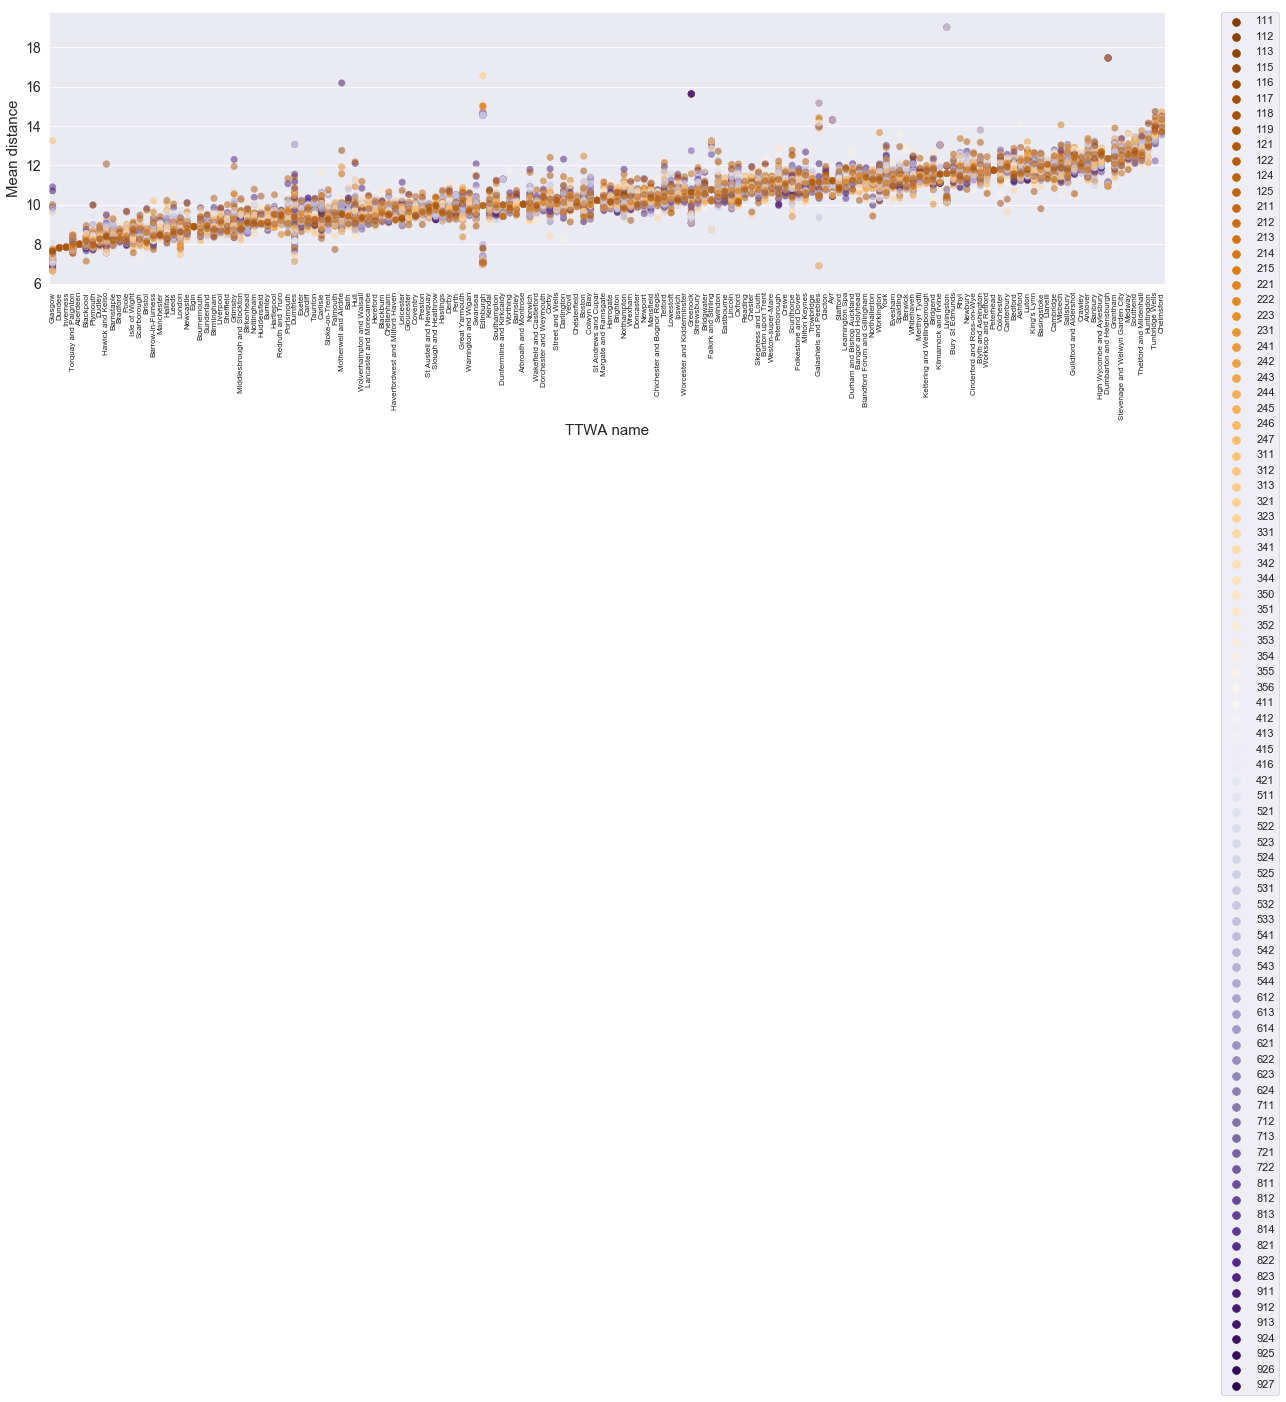

In [60]:
# try the last plot, that is plot all TTWA on the x axis and each occupation as a different line
plt.figure(figsize = (20,5))
with sns.plotting_context('paper'):
    g = sns.stripplot(x='TTWA name',y='Mean distance',hue='Occupation code',data = distances_data,
                 order = ordered_ttwa_names, size = 7, jitter = False, alpha = 0.5, palette = 'PuOr')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_ylabel(g.get_ylabel(), fontsize = 15)
    g.set_xlabel(g.get_xlabel(), fontsize = 15)
    g.axes.tick_params(axis = 'y', labelsize =14)
    g.axes.tick_params(axis = 'x', labelsize =8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 11)
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_ordered_3d-SOC-workers_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

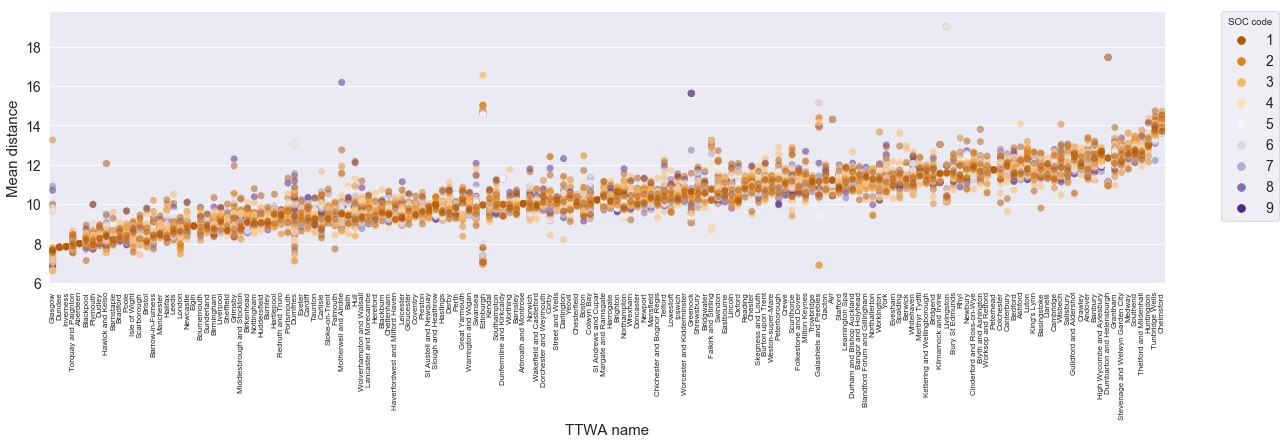

In [61]:
# same plot as above, but group by first digit of SOC
plt.figure(figsize = (20,5))
with sns.plotting_context('paper'):
    g = sns.stripplot(x='TTWA name',y='Mean distance',hue='Occupation first digit',data = distances_data,
                 size = 7, jitter = False, order = ordered_ttwa_names, alpha = 0.5, 
                      palette = 'PuOr')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_ylabel(g.get_ylabel(), fontsize = 15)
    g.set_xlabel(g.get_xlabel(), fontsize = 15)
    g.axes.tick_params(axis = 'y', labelsize =14)
    g.axes.tick_params(axis = 'x', labelsize =8)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize = 14, title = 'SOC code')
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_ordered_1d-SOC-workers_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

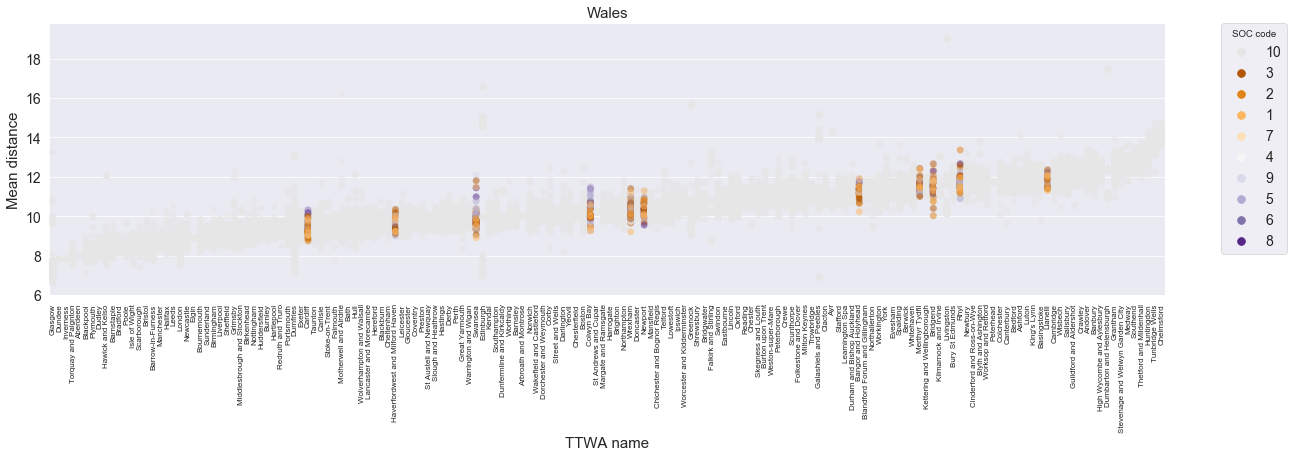

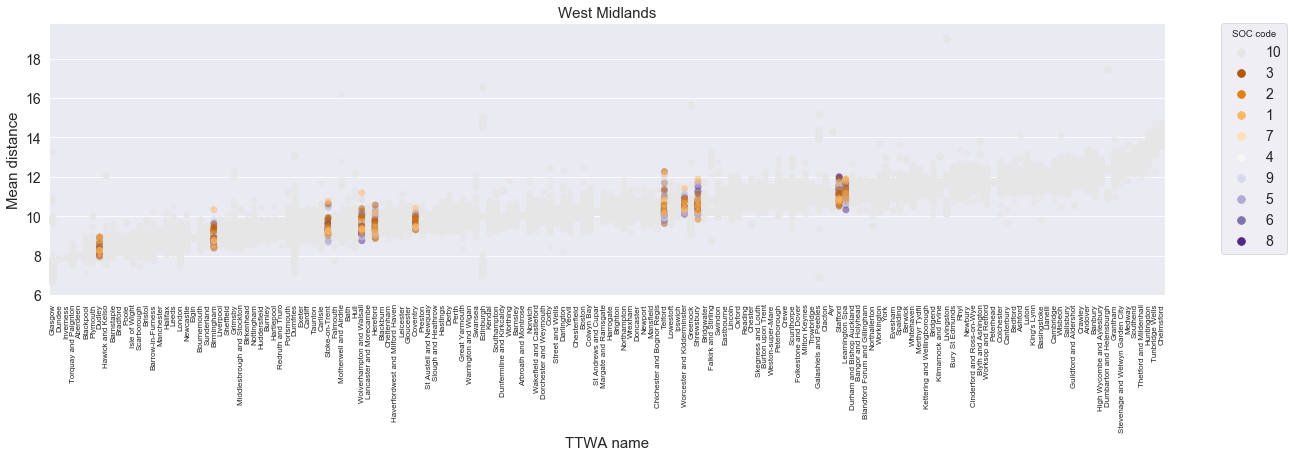

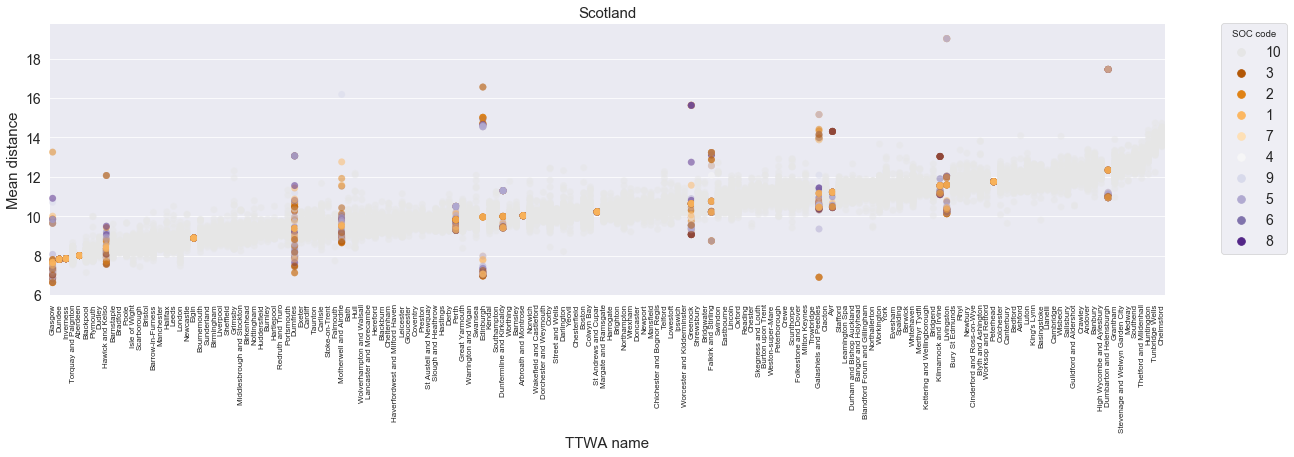

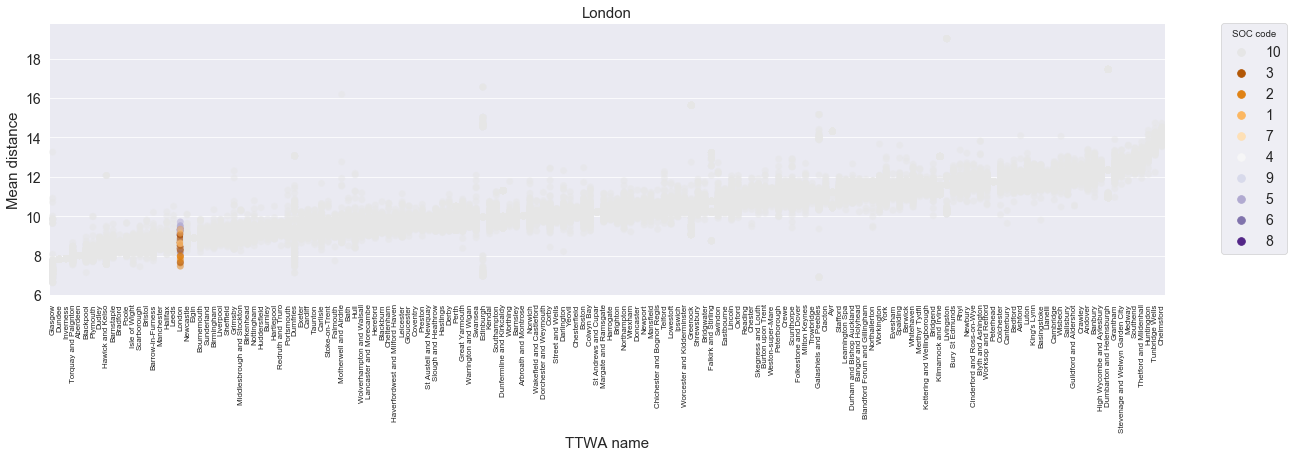

In [62]:
# same plot as above, but group by first digit of SOC and grey out points not belonging to the region of interest
def greyout_SOC_by_region(df,region):
    #for row in df.index:
    if df['Region'] != region:
        df['tmp'] = 10
    else:
        df['tmp'] = df['Occupation first digit']
    return df

# prepare the color palette:
palette = sns.color_palette(palette = 'PuOr',n_colors = 9)
palette = [(0.9,0.9,0.9)] + palette
df = copy.deepcopy(distances_data)
df['tmp'] = 1
with sns.plotting_context('paper'):
    for region in ['Wales','West Midlands', 'Scotland','London']:
        plt.figure(figsize = (20,5))
        g = sns.stripplot(x='TTWA name',y='Mean distance',hue='tmp',palette = palette,
                          data = df.apply(lambda x: greyout_SOC_by_region(x,region),axis = 1),
                     size = 7, jitter = False, order = ordered_ttwa_names, alpha = 0.5)
        g.set_xticklabels(g.get_xticklabels(),rotation=90)
        g.set_ylabel(g.get_ylabel(), fontsize = 15)
        g.set_xlabel(g.get_xlabel(), fontsize = 15)
        g.axes.tick_params(axis = 'y', labelsize =14)
        g.axes.tick_params(axis = 'x', labelsize =8)
        g.axes.set_title(region, fontsize = 15)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize = 14, title = 'SOC code')
        if FIGSAVE:
            plt.savefig(os.path.join(plot_save_dir,
                                     'avg_commuting_distance_ordered_1d-SOC-workers_region{}_{}.png'.format(region,
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

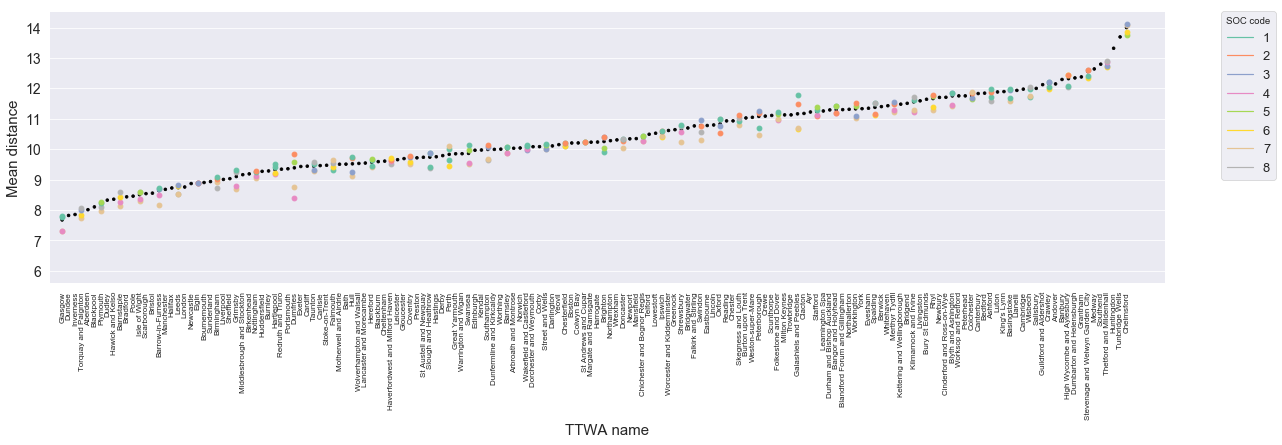

In [63]:
# same plot as above,but only plot the 2 fastest and slowest occupations (1st digit) per TTWA
# define occupations colors
occupations_colours = sns.color_palette('Set2',9)
# group again by TTWA
groups = distances_data.groupby('TTWA')

plt.figure(figsize = (20,5))
with sns.plotting_context('paper'):
    g = sns.pointplot(data= distances_data, x = 'TTWA name', y = 'Mean distance', 
                      ci = None, join = False, order = ordered_ttwa_names, color = 'k', scale = 0.5)
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.set_ylabel(g.get_ylabel(), fontsize = 15)
    g.set_xlabel(g.get_xlabel(), fontsize = 15)
    g.axes.tick_params(axis = 'y', labelsize =14)
    g.axes.tick_params(axis = 'x', labelsize =8)
    # get the fastest and slowest occupations by TTWA
    for ii,ttwa in enumerate(ordered_ttwa[::3]):
        group = groups.get_group(ttwa)
        # group again by first digit occupation, take the average mean distances, order them
        tmp =group.groupby('Occupation first digit').apply(
            np.mean).sort_values('Mean distance')
        #occ_order = np.argsort(group['Mean distance'])
        for pos in [0,1,6,7]:
            plt.plot(ii*3,tmp['Mean distance'].iloc[pos],'o', 
                 color = occupations_colours[int(tmp.index[pos])-1])
    # add the legend
    # create fake points for the occupations
    for pos in range(8):
        plt.plot(10,6, markersize = 0, 
                 color = occupations_colours[pos], label = '{}'.format(pos+1))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize = 13, title = 'SOC code')
    g.set_xlim([-2,171])
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_ordered_1d-SOC-workers_{}subset.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

In [64]:
### for each occupation code (maybe 1st digit SOC), find those TTWAs for which they have a commuting distance that
# differ from the mean more than N standard deviations (presumably it will be N=2 or 3)
print('TODO!')
#print(list(ttwa_info11.index))

TODO!


In [65]:
# compute various averages across regions
distances_grouped = distances_data.groupby('TTWA').agg(np.mean).reset_index()
distances_grouped['Region'] = distances_grouped.apply(lambda x: assign_region(x,ttwa_info16), axis = 1)
distances_grouped.head(n=3)

TTWA  Mean distance   best  worst                    Region
0  E30000004      10.008884  False  False  Yorkshire and The Humber
1  E30000018       8.435795   True  False  Yorkshire and The Humber
2  E30000029       8.726885   True  False  Yorkshire and The Humber

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



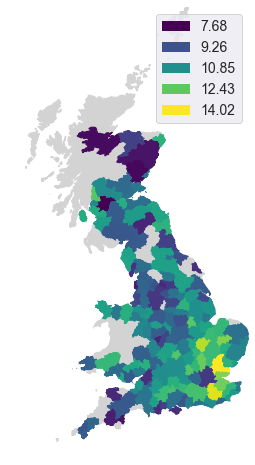

In [128]:
# now, plot mean (or median) commuting distance for each TTWA on a map
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(distances_grouped, 'Mean distance', 'viridis', 
         np.percentile(distances_data['Mean distance'],1), np.percentile(distances_data['Mean distance'],99), 
             gb_filename,
         None, ttwa_shp_filename, roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_map_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)
        
distances_grouped = distances_grouped.assign(Mean_distance_deviation = 
                         distances_grouped['Mean distance']/distances_grouped['Mean distance'].mean())

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



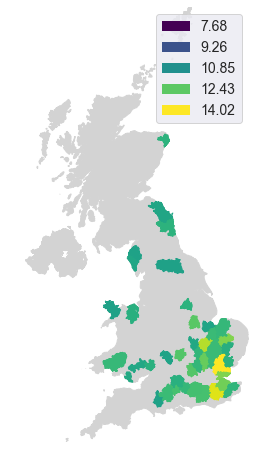

In [67]:
# now, plot mean (or median) commuting distance for each TTWA on a map
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(distances_grouped[distances_grouped['worst']], 'Mean distance', 'viridis', 
         np.percentile(distances_data['Mean distance'],1), np.percentile(distances_data['Mean distance'],99), 
             gb_filename,
         ni_filename, ttwa_shp_filename, roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_longest_map_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)


/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



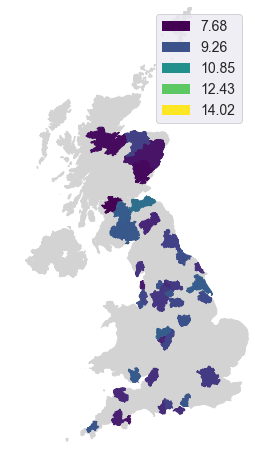

In [68]:
# now, plot mean (or median) commuting distance for each TTWA on a map
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(distances_grouped[distances_grouped['best']], 'Mean distance', 'viridis', 
         np.percentile(distances_data['Mean distance'],1), np.percentile(distances_data['Mean distance'],99), 
             gb_filename,
         ni_filename, ttwa_shp_filename, roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_shortest_map_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

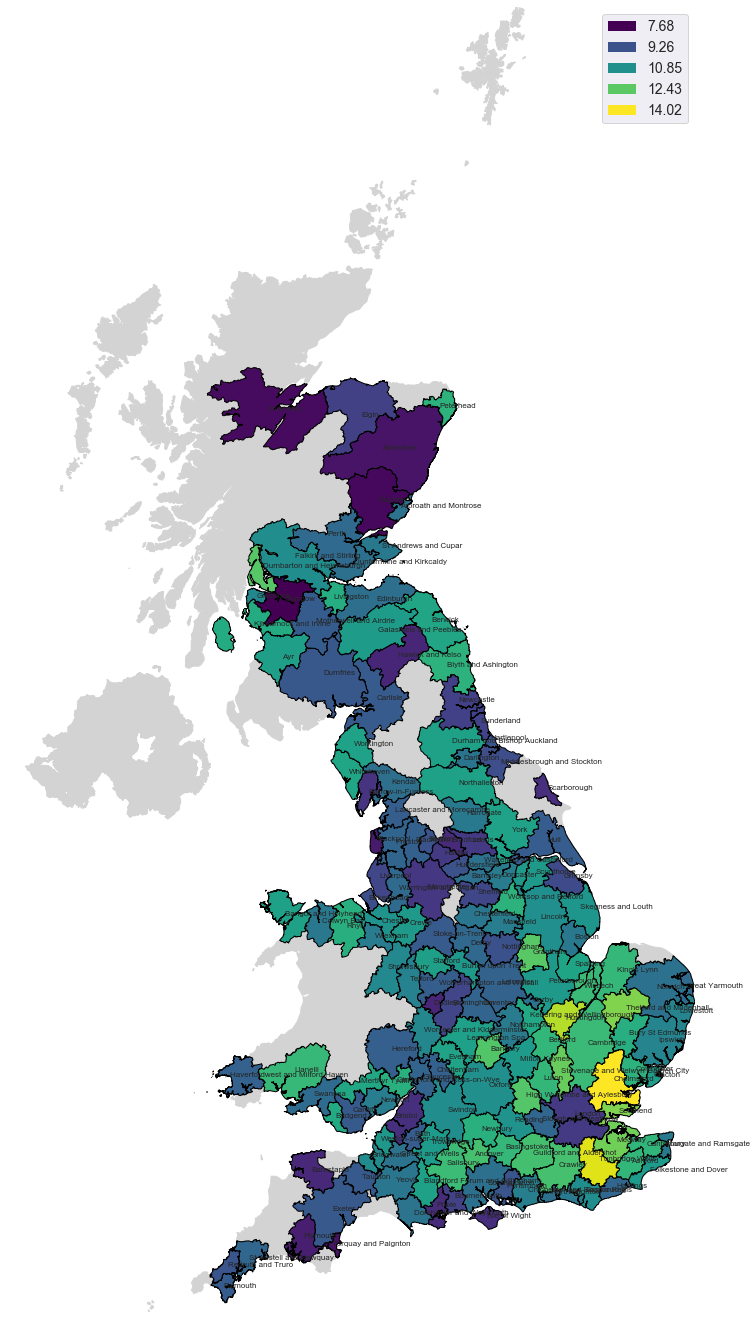

In [70]:
import utils_pin
reload(utils_pin)
fig,ax = plt.subplots(figsize = (12,24))
_ = maputils_pin.draw_map_and_landmarks(distances_grouped, 'Mean distance', 'viridis', 
         np.percentile(distances_data['Mean distance'],1), np.percentile(distances_data['Mean distance'],99), 
                                     gb_filename,
         ni_filename, ttwa_shp_filename, roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False}, add_names = True)
if FIGSAVE or True:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_map_with_names_.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)


In [71]:
'''
# replot the same, but divided by the overall mean
fig,ax = plt.subplots(figsize = (5,8))
_ = draw_map(distances_grouped, 'Mean_distance_deviation', 'viridis', 
     np.min(distances_grouped['Mean_distance_deviation']), np.max(distances_grouped['Mean_distance_deviation']), 
     gb_filename, ni_filename, ttwa_shp_filename, roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax,
     params={'SAVEFIG': False, 'file_name': os.path.join(plot_save_dir,'avg_commuting_distance_deviation_map.png')})
'''
print('not needed')

not needed


### Location quotients

We can compute multiple location quotients - but in general we need to consider two axis of variations: 

- geographical location (either TTWA or region) and larger reference area (region or nation)
- commuting distance distribution across SOC codes

We can compute:
- which SOC code has the highest location quotient when comparing TTWAs in each region (whitin region differences)
- which SOC code has the highest LQ when comparing TTWAs in the whole of the UK
- which SOC code has the highes LQ when comparing regions against the national average


In [72]:
def compute_lq(local_dist, reference_dist):
    '''
    local_dist is the matrix of average commuting distances per SOC codes per local area (TTWA x SOC codes)
    reference_dist is the vector of average commuting distsnces per SOC codes in the reference area (1 x SOC codes)
    It returns the LQ matrix (TTWA x SOC codes), as well as the SOC code with highest LQ per local area (TTWA x 0)
    '''
    local_ratio = local_dist/np.sum(local_dist, axis = 1, keepdims = True)
    reference_ratio = reference_dist/np.sum(reference_dist)
    local_lq = local_ratio/reference_ratio
    max_local_soc = np.argmax(local_lq, axis = 1)
    return local_lq, max_local_soc+1
    

In [73]:
# compute the average commuting distance per SOC code per region
regional_average= distances_data.groupby(['Region','Occupation first digit']).agg(np.mean)['Mean distance']
# compute the national average per SOC code
national_average = distances_data.groupby(['Occupation first digit']).agg(np.mean)['Mean distance']

In [74]:
# compute a location quotient for each first digit SOC code and each TTWA in a region when comparing to the
# regional average
all_lq_within = {}
for region,group in distances_data.groupby('Region'):
    # collect all TTWAs for each region, and take the average for each TTWA and Occupation first digit
    local_df = group[['TTWA','Mean distance','Occupation first digit']].groupby(
        ['TTWA','Occupation first digit']).agg(np.mean)
    ttwa_names, first_digits = local_df.index.levels
    local_matrix = np.reshape(np.array(local_df.values),(-1,9))
    LQ1,LQ2 = compute_lq(local_matrix,regional_average[region].values[:,np.newaxis].T)
    all_lq_within[region] = pd.DataFrame(np.concatenate((LQ1,LQ2[:,np.newaxis]),axis = 1), 
                       columns = list(first_digits.values)+['highest SOC'], index = ttwa_names)

for t, region in enumerate(all_lq_within):
    all_lq_within[region] = all_lq_within[region].reset_index()

# compute a location quotient for each first digit SOC code and each TTWA in a region when comparing to the
# national average
local_df = distances_data.groupby(['TTWA','Occupation first digit']).agg(np.mean)['Mean distance'].reset_index(
    ).pivot(index = 'TTWA',columns = 'Occupation first digit')
LQ1,LQ2 = compute_lq(np.array(local_df), national_average.values[:,np.newaxis].T)
all_lq_uk = pd.DataFrame(np.concatenate((LQ1,LQ2[:,np.newaxis]), axis =1), 
                         columns = list(first_digits.values)+['highest SOC'], index = local_df.index)

# compute a location quotient for each region, as compared with the national average
local_df = distances_data.groupby(['Region','Occupation first digit'])['Mean distance'].agg(np.mean
                            ).reset_index().pivot(index = 'Region',columns = 'Occupation first digit')
LQ1,LQ2 = compute_lq(np.array(local_df), national_average.values[:,np.newaxis].T)
all_lq_regions = pd.DataFrame(np.concatenate((LQ1,LQ2[:,np.newaxis]), axis =1), 
                         columns = list(first_digits.values)+['highest SOC'], index = local_df.index)

# join the latter with the former, by assigning the same SOC code to all TTWA in the same region
all_lq_uk = all_lq_uk.assign(highest_SOC_regional = -1)
for ttwa in all_lq_uk.index:
    all_lq_uk['highest_SOC_regional'].loc[ttwa] = all_lq_regions['highest SOC'].loc[
        ttwa_info16['Region/Country'].loc[ttwa]]
    

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



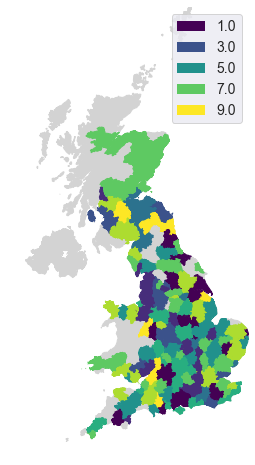

In [75]:
# first, plot the easy ones
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(all_lq_uk.reset_index(), 'highest SOC', 'viridis', 1, 9, gb_filename,
         ni_filename, ttwa_shp_filename, roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_map_lq_ttwa_vs_nation_.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



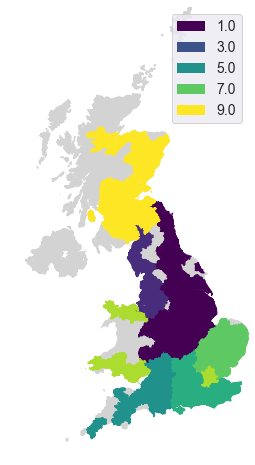

In [76]:
fig,ax = plt.subplots(figsize = (4,8))
_ = draw_map(all_lq_uk.reset_index(), 'highest_SOC_regional', 'viridis', 1, 9, gb_filename,
         ni_filename, ttwa_shp_filename, roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax,
         params={'SAVEFIG': False})
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_map_lq_region_vs_nation_{}.png'.format(
        ni_qual)), bbox_inches = 'tight', dpi = 300, quality = 95)

/Users/stefgarasto/Google Drive/Documents/data/Map-files/Regions_December_2018_EN_BFC/Regions_December_2018_EN_BFC.shp


/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.

/Users/stefgarasto/miniconda3/envs/mapping/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning:

Setting the 'color' property will overridethe edgecolor or facecolor properties.



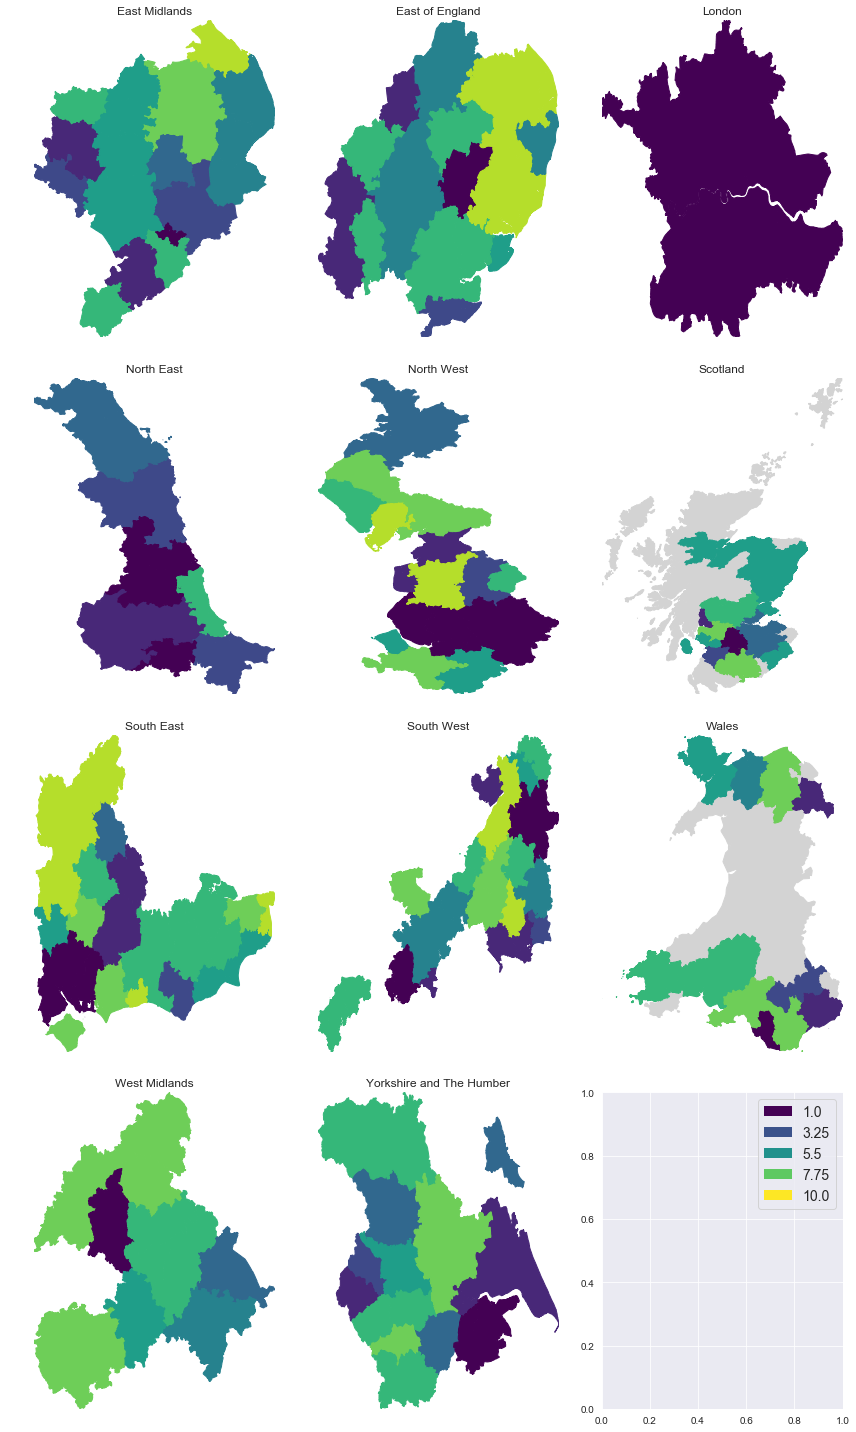

In [80]:
fig, ax = plt.subplots(4,3, figsize = (12,20))
reload(utils_pin)
# prepare dictionary of shapefiles and subsets to pass (we only want to plot each region)
map_shp = {'Scotland': gb_filename, 'Wales': gb_filename}
regions_filename = map_files_folder + 'Regions_December_2018_EN_BFC/Regions_December_2018_EN_BFC.shp'
for region in ['North East','North West','Yorkshire and The Humber','East Midlands','West Midlands',
               'East of England','London','South East','South West']:
    map_shp[region] = regions_filename
print(map_shp[list(all_lq_within.keys())[0]])
for ix, region in enumerate(all_lq_within.keys()):
    i, j = np.unravel_index(ix,(4,3))
    if region=='NI':
        _ = maputils_pin.draw_map(all_lq_within[region], 'highest SOC', 'viridis', 1, 10, gb_filename, 
                 ni_filename, ttwa_shp_filename, subset_outlines = [region],
                 roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax[i,j],
                 params={'SAVEFIG': False})
    else:
        _ = maputils_pin.draw_map(all_lq_within[region], 'highest SOC', 'viridis', 1, 10, gb_filename, #map_shp[region], 
                 None, ttwa_shp_filename, subset_outlines = [region],
                 roi_col = 'TTWA', shp_col = 'ttwa11cd', fig = fig, ax = ax[i,j],
                 params={'SAVEFIG': False})
    ax[i,j].set_title(region)

plt.tight_layout()
        
if FIGSAVE:
    plt.savefig(os.path.join(plot_save_dir,'avg_commuting_distance_map_lq_ttwa_vs_region.png'), dpi=300, quality=95)

In [68]:
'''
Check memory usage of all variables
'''
'''
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') 
        and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
'''
print('Finished')

Finished
